# base_v3-log_bp.ipynb

Supposed to be a base_v3 version with logarithmic AF units and bp M__C synapses, but currently it's not even using logarithmic units. Not sure where this got branched from.  
Possibly -Copy1 is a bit more advanced.

In [1]:
%cd ../..
import numpy as np
import matplotlib.pyplot as plt
import time

/home/z/projects/draculab


In [2]:
%load_ext Cython

In [3]:
%%cython
from draculab import *

In [4]:
##################################
####### Create the network #######
##################################

# simulation control parameters
t_pres = 25. # number of seconds to hold each set of target lengths
rand_w = False # whether to use random weights in M->C, AF->M
rga_diff = True # whether to use rga_diff synapses in M__C

# First the network object, the plant, the list of coordinates
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 10 }
P_params = {  'type' : plant_models.bouncy_planar_arm_v3,
          'mass1': 1.,
          'mass2': 1.,
          's_min' : -0.4,
          'p1' : (-0.01, 0.04),
          'p2' : (0.29, 0.03),
          'p3' : (0., 0.05),
          'p5' : (0.01, -0.05),
          'p10': (0.29, 0.03),
          'init_q1': 0.,
          'init_q2': np.pi/2.,
          'init_q1p': 0.,
          'init_q2p': 0.,
          'g': 0.0,
          'mu1': 1.,
          'mu2': 1.,
          'l_torque' : 0.01,
          'l_visco' : 0.01,
          'g_e' : 20.,
          'l0_e' : [1.]*6,
          'Ia_gain' : 2.5*np.array([3.,10.,10., 3.,10.,10.]),
          'II_gain' : 2.*np.array([3., 8., 8., 3., 8., 8.]),
          'Ib_gain' : 1.,
          'T_0' : 10.,
          'k_pe_e' : 2.,  #8
          'k_se_e' : 20., #13
          'b_e' : 5.,
          'g_s' : 0.02,
          'k_pe_s' : 2., 
          'k_se_s' : 2.,
          'g_d' : 0.01,
          'k_pe_d' : .2, #.1,
          'k_se_d' : 1., #2.,
          'b_s' : .5,
          'b_d' : 2.,#3.,
          'l0_s': .7,
          'l0_d': .8,
          'fs' : 0.1,
          'se_II' : 0.5,
          'cd' : 0.5,
          'cs' : 0.5,
          'tau' : 0.1   # ficticious time constant used in create_freqs_steps
           }
net = network(net_params)
P = net.create(1, P_params)
arm = net.plants[P]

# We organize the spinal connections through 4 types of symmetric relations
# these lists are used to set intraspinal connections and test connection matrices
antagonists = [(0,3), (1,2), (4,5)]
part_antag = [(0,2),(0,5), (3,4), (1,3)]
synergists = [(0,1), (0,4), (2,3), (3,5)]
part_syne = [(1,4), (2,5)]
self_conn = [(x,x) for x in range(6)]

antagonists += [(p[1],p[0]) for p in antagonists]
part_antag += [(p[1],p[0]) for p in part_antag]
synergists += [(p[1],p[0]) for p in synergists]
part_syne += [(p[1],p[0]) for p in part_syne]
all_pairs = [(i,j) for i in range(6) for j in range(6)]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# UNIT PARAMETER DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
par_heter = 0.05 # range of heterogeneity as a fraction of the original value
#randz1 = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz6 = lambda : (1. + par_heter*(np.random.rand(6)-0.5))
randz12 = lambda : (1. + par_heter*(np.random.rand(12)-0.5))
randz18 = lambda : (1. + par_heter*(np.random.rand(18)-0.5))
randz36 = lambda : (1. + par_heter*(np.random.rand(36)-0.5))

ACT_params = {'type' : unit_types.act,
              'tau_u' : 8.,
              'gamma' : 2.,
              'g' : 2.,
              'theta' : 1.,
              'tau_slow' : 5.,
              'y_min' : 0.2,
              'rst_thr' : 0.1,
              'init_val' : 0. }
spf_sum_min = .4 # value where no corrections are needed anymore
y_min = 1./(1. + np.exp(-ACT_params['g']*(spf_sum_min - ACT_params['theta'])))
ACT_params['y_min'] = y_min

AF_params = {'type' : unit_types.logarithmic,
             'init_val' :  [1.69521365e-03, 1.38066930e-04, 8.22826241e-03, 4.57382536e-03,
                           2.63279923e-03, 1.33950962e-03, 3.96717388e-02, 1.76216213e-01,
                           5.42828194e-02, 1.56028196e-02, 6.89968040e-02, 9.08714994e-02,
                           5.11518045e-02, 1.99303055e-01, 2.45623689e-02, 1.86245176e-02,
                           1.86034265e-02, 9.97734455e-02] + [0.00000000e+00, 0.00000000e+00,
                           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
                            1.82035549e-03, 1.02861722e-01, 4.72605123e-03, 2.08303105e-04,
                            9.28135655e-03, 4.66304248e-02, 0.00000000e+00, 3.96374006e-02,
                            0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.82790315e-06],
             'tau' : 0.02 * randz36(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             #'tau_slow' : 400., # using a slow value, so init_val is important
             'delay' : 0.1,
             'thresh' :  np.concatenate((np.array([0.08, 0.24, 0.08, 0.07, 0.11, 0.20,
                          0.07, -.08, 0.34, 0.13, 0.19, 0.05,
                          0.21, -.06, 0.55, 0.30, 0.36, 0.10]), np.array(
                         [0.08, 0.24, 0.08, 0.07, 0.11, 0.20,
                          0.07, -.08, 0.34, 0.13, 0.19, 0.05,
                          0.21, -.06, 0.55, 0.30, 0.36, 0.10]) -.1)) }
AL_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.3 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.1 * randz6(),
             'tau' : 0.05 * randz6() }
CE_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 2.5 * randz6(),
             'slope' : 1.5 * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : .1,
             'integ_decay' : 0.1,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
CI_params = {'type' : unit_types.gated_rga_inpsel_adapt_sig,
             'thresh' : 3.5 * randz6(),
             'slope' : 2. * randz6(),
             'init_val' : 0.2 * randz6(),
             'tau' : 0.5 * randz6(), #0.02 * randz6(),
             'tau_fast': 0.1,
             'tau_mid' : 1.,
             'tau_slow' : 6.,
             'custom_inp_del' : 15,
             'integ_amp' : .1,
             'integ_decay' : 0.2,
             'adapt_amp' : 8.,
             'delay' : 0.2,
             'des_out_w_abs_sum' : 1. }
M_params = {'type' : unit_types.gated_out_norm_am_sig,
            'thresh' : 0. * randz12(),
            'slope' : 3. * randz12(),
            'init_val' : 0.2 * randz12(),
            'delay' : 0.2,
            'tau_fast': 0.1,
            'tau_mid': 1.,
            'tau_slow' : 4.,
            'tau' : 0.01 * randz12(),
            'p0_inp' : 0.0,
            'des_out_w_abs_sum' : 3. }
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : [3.96717388e-02, 1.76216213e-01,  # AF time averages
                        5.42828194e-02, 1.56028196e-02, 6.89968040e-02, 9.08714994e-02,
                        5.11518045e-02, 1.99303055e-01, 2.45623689e-02, 1.86245176e-02,
                        1.86034265e-02, 9.97734455e-02],
             'slope' : 8.*np.array([3.47, 2.29, 4.0, 4.0,  3.71, 2.83,
                                 3.08, 1.89, 4.0, 3.91, 3.58, 2.20]),
             'init_val' : 0.2 * randz12(),
             'tau' : 0.03 * randz12() } 
SP_params = {'type' : unit_types.source,
             'init_val' : 0.5,
             'tau_fast' : 0.02,
             'tau_mid' : 0.1,
             'function' : lambda t: None }
SP_CHG_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.3,
              'slope' : 9.,
              'init_val' : 0.1,
              'tau' : 0.01 }
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.4 * randz12(),
              'slope' : 6. * randz12(),
              'init_val' : 0.3 * randz12(),
              'tau_fast': 0.05,
              'tau_mid': 0.5,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz12() }
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTION DICTIONARIES
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# ACT to CE,CI ------------------------------------------------
ACT__CE_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CE_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
ACT__CI_conn = {'rule' : "all_to_all",
                'delay' : 0.02 } 
ACT__CI_syn = {'type' : synapse_types.static,
               'inp_ports' : 4,
               'init_w' : 1. }
# AF to CE, CI --------------------------------------------------
AF__CE_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CE_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 1.,
              'lrate' : 10.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
AF__CI_conn = {'rule' : 'all_to_all',
               'delay' : 0.02 }
AF__CI_syn = {'type' : synapse_types.gated_inp_sel,
              'aff_port' : 2,
              'inp_ports' : 2,
              'error_port' : 0,
              'normalize' : True,
              'w_sum' : 1.,
              'lrate' : 10.,
              'extra_steps' : 1,
              'init_w' : 0.05 }
# AF to M ------------------------------------------------
## Creating a test matrix
if not rand_w:
    # Initializing manually
    AF_M = np.zeros((36, 12)) # rows are source, columns target
    for src in range(36):
        for trg in range(12):
            src_pop = src%6 #src's population
            trg_pop = trg%6 #trg's population
            if src%18 < 6: # if the afferent is tension, don't reverse signs
                sig = 1
            else:
                sig = -1
            if src > 17: sig = -sig # if 'negative' afferent reverse sign
            for pair in antagonists:
                if pair == (src_pop, trg_pop):
                    AF_M[src, trg] = sig*0.2
                    break
            else: 
                for pair in part_antag:
                    if pair == (src_pop, trg_pop):
                        AF_M[src, trg] = sig*0.1
                        break
                else: 
                    for pair in synergists:
                        if pair == (src_pop, trg_pop):
                            AF_M[src, trg] = sig*-0.2
                            break
                    else: 
                        for pair in synergists:
                            if pair == (src_pop, trg_pop):
                                AF_M[src, trg] = sig*-0.2
                                break
                        else: 
                            for pair in part_syne:
                                if pair == (src_pop, trg_pop):
                                    AF_M[src, trg] = sig*-0.1
                                    break
                            else:
                                if src_pop == trg_pop:
                                    AF_M[src, trg] = sig*-0.3
else:
    #AF_M = 0.2*(np.random.random((12,12)) - 0.5) # random initial connections!!!!!
    AF_M = 0.2*(np.random.random((12,36)) - 0.5) # random initial connections!!!!!

AF__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
AF__M_syn = {'type' : synapse_types.gated_diff_inp_sel,
            'aff_port' : 0,
            'error_port' : 1,
            'normalize' : True,
            'w_sum' : 10.,
            'inp_ports' : 0, # afferent for out_norm_am_sig
            'input_type' : 'pred', # if using inp_corr
            'lrate' : 0., #20.,
            'extra_steps' : None, # placeholder value; filled below,
            'init_w' : AF_M.flatten() }
# AF to SF ------------------------------------------------
AF__SF_conn = {'rule' : 'one_to_one',
              'delay' : 0.02 }
AF__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# AL to P ------------------------------------------------
AL__P_conn = {'inp_ports' : list(range(6)),
             'delays': 0.01 }
AL__P_syn = {'type': synapse_types.static,
            'init_w' : 1. }
# CE, CI to AL ----------------------------------------------
CE__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__AL_syn = {'type' : synapse_types.static,
              'init_w' : [1., 1., 1., 1., 1., 1.] }
CI__AL_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__AL_syn = {'type' : synapse_types.static,
              'init_w' : -1. }
# CE,CI to CE,CI  ------------------------------------------------
CE__CI_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CI__CE_conn = {'rule' : 'one_to_one',
               'delay' : 0.01 }
CE__CI_syn = {'type' : synapse_types.static,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'init_w' : 1.5 }
CI__CE_syn = {'type' : synapse_types.static, #static, #corr_inh,
              'inp_ports' : 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
              'lrate' : .0,
              'des_act' : 0.5,
              'init_w' : -2.5 }
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : 1.,
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_p_antag = {'type' : synapse_types.static, #bcm,
                  'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                  'init_w' : .2,
                  'lrate' : 1.,
                  'des_act' : 0.5 }
C__C_syn_syne = {'type' : synapse_types.static,
                 'inp_ports': 1,
                 'lrate' : 1.,
                 'init_w' : .5 }
C__C_syn_p_syne = {'type' : synapse_types.static,
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0.2 }
C__C_syn_null_lat = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 1,
                   'lrate' : 1.,
                   'init_w' : 0. }
C__C_syn_null_aff = {'type' : synapse_types.static, # connection with static weight zero
                   'inp_ports': 2, #1, # IN AFFERENT PORT!!!!!!!!!!!!!!!!!!!!!! May affect normalization of afferent inputs
                   'lrate' : 1.,
                   'init_w' : 0. }
# M to CE,CI ----------------------------------------------
# creating a test matrix
if not rand_w:
    # initializing manually
    M_CE = np.array(
        [[ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3],
         [ 0.2,  0.1, -0.1, -0.2,  0.1, -0.1],
         [ 0.1,  0.2, -0.2, -0.1,  0.1,  0.0],
         [-0.1, -0.2,  0.2,  0.1,  0.0,  0.0],
         [-0.2, -0.1,  0.1, -0.2, -0.1,  0.1],
         [ 0.1,  0.0,  0.0, -0.1,  0.3, -0.2],
         [-0.1,  0.0,  0.0,  0.1, -0.2,  0.3]])
    M_CI = -M_CE
else:
    M_CE = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
    M_CI = 0.4*(np.random.random((12,6)) - 0.5) # random initial connections!!!!!
if rga_diff:
    M__C_type = synapse_types.gated_rga_diff
else:
    M__C_type = synapse_types.gated_bp_rga
M__CE_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CE_syn = {'type' : M__C_type,
             'inp_ports' : 0,
             'lrate' : 0.,
             'w_sum' : 3.,
             'w_thresh' : .05,
             'w_tau' : 60.,
             'w_decay': 0.005,
             'init_w' : M_CE.flatten() }
M__CI_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__CI_syn = {'type' : synapse_types.gated_bp_rga,
             'inp_ports' : 0,
             'lrate' : 0.,
             'w_sum' : 3,
             'w_thresh' : .05,
             'w_tau' : 60.,
             'w_decay': 0.005,
             'init_w' : M_CI.flatten() }
# P to AF  ---------------------------------------------------
idx_aff = np.arange(22,40) # indexes for afferent output in the arm
P__AF_conn = {'port_map' : [[(p,0)] for p in idx_aff],
             'delays' : 0.02 }
Pe__AF_syn = {'type' : synapse_types.static,
              'init_w' : [1.]*18 } 
Pi__AF_syn = {'type' : synapse_types.static,
            'init_w' :  [-1.]*18 }
# SF, SP to SPF ------------------------------------------------
SFe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "one_to_one",
                 'delay' : 0.02 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP to SP_CHG ------------------------------------------------
SP__SP_CHG_conn = {'rule' : 'all_to_all',
                    'delay' : 0.01}
SP__SP_CHG_syn = {'type' : synapse_types.chg,
                  'init_w' : 0.,
                  'lrate' : 20. }
# SP_CHG to CE, CI ------------------------------------------------
SP_CHG__CE_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__CE_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
SP_CHG__CI_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__CI_syn = {'type' : synapse_types.static,
                  'inp_ports' : 3,
                  'init_w' : 1. }
# SP_CHG to ACT ------------------------------------------------
SP_CHG__ACT_conn = {'rule' : "all_to_all",
                   'delay' : 0.02 }
SP_CHG__ACT_syn = {'type' : synapse_types.static,
                  'inp_ports' : 1,
                  'init_w' : 1. }
# SP_CHG to M ------------------------------------------------
SP_CHG__M_conn = {'rule' : "all_to_all",
                  'delay' : 0.02 }
SP_CHG__M_syn = {'type' : synapse_types.static,
                  'inp_ports' : 2,
                  'init_w' : 1. }
# SPF to ACT ------------------------------------------------
SPF__ACT_conn = {'rule' : "all_to_all",
                 'delay' : 0.02 }
SPF__ACT_syn = {'type' : synapse_types.static,
                'inp_ports' : 0,
                'init_w' : 1. }
# SPF to M  ------------------------------------------------
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static, #synapse_types.inp_corr,
              'inp_ports' : 1,
              'lrate' : 0.,
              'input_type' : 'error', # if using inp_corr
              'init_w' : 2. }

#*************************************************************
# Setting the right delay for AF-->M
f = 1. # going to estimate the extra delay of error inputs wrt afferent inputs at M
w = 2.*np.pi*f
sf_del = np.arctan(np.mean(SF_params['tau'])*w)/w
spf_del = np.arctan(np.mean(SPF_params['tau'])*w)/w
delay = spf_del + sf_del + AF__SF_conn['delay'] + SFe__SPF_conn['delay']
steps = int(round(delay/net.min_delay))
AF_params['delay'] = AF_params['delay'] + (
                     net_params['min_delay'] * (np.ceil(delay/net_params['min_delay']) + 1))
AF__M_syn['extra_steps'] = steps
#*************************************************************
# utilitiy function for the M-->C delays used in the rga rule
def approx_del(f):
    """ Returns an estimate fo the optimal delay for rga learning.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-AL-P-AF-M-C.
        We also assume the delays to/from CI are the same as the ones for CE.
        
        Args:
            f : oscillation frequency of E-I pair in C, in Hertz
        Returns:
            2-tuple : (time_del, del_steps)
            time_del : A float with the time delay.
            del_steps : time delay as integer number of min_del steps.
    """
    w = 2.*np.pi*f
    al_del = np.arctan(np.mean(AL_params['tau'])*w)/w
    p_del = np.arctan(np.mean(P_params['tau'])*w)/w
    af_del = np.arctan(np.mean(AF_params['tau'])*w)/w
    m_del = np.arctan(np.mean(M_params['tau'])*w)/w
    D = [CE__AL_conn['delay'], AL__P_conn['delays'], np.mean(P__AF_conn['delays']),
         AF__M_conn['delay'], M__CE_conn['delay'] ]
    time_del = al_del + p_del + af_del + m_del + sum(D)
    del_steps = int(np.ceil(time_del/net_params['min_delay']))
    time_del = del_steps*net_params['min_delay']
    del_steps -= 1 # because this is an index, and indexes start at 0
    return time_del, del_steps
############## Approximating the delays for the rga rule #############
######## Using the utility function (for rga synapses)
# time_del, del_steps = approx_del(0.01) #0.65 was approximate CE/CI frequency observed in simulations
# #time_del, del_steps = (1., 200-1)
# CE_params['delay'] = time_del
# CI_params['delay'] = time_del
# M_params['delay'] = time_del
# CE_params['custom_inp_del'] = del_steps
# CI_params['custom_inp_del'] = del_steps
######## Using the two custom delays (for rga_diff synapses)
dely1 = 0.25
dely2 = 0.75 # we need dely2 > dely1
del_steps1 = int(np.ceil(dely1/net_params['min_delay'])) - 1
del_steps2 = int(np.ceil(dely2/net_params['min_delay'])) - 1
CE_params['delay'] = dely2
CI_params['delay'] = dely2
M_params['delay'] = dely2
CE_params['custom_inp_del'] = del_steps1
CI_params['custom_inp_del'] = del_steps1
CE_params['custom_inp_del2'] = del_steps2
CI_params['custom_inp_del2'] = del_steps2
#*************************************************************

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CREATING UNITS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ACT = net.create(1, ACT_params)
AF = net.create(36, AF_params)
AL = net.create(6, AL_params)
CE = net.create(6, CE_params)
CI = net.create(6, CI_params)
M = net.create(12, M_params)
SF = net.create(12, SF_params)
SP = net.create(12, SP_params)
SP_CHG = net.create(1, SP_CHG_params)
SPF = net.create(12, SPF_params)

# SET THE PATTERNS IN SP -----------------------------------------------------
# list with hand coordinates [x,y] (meters)
hand_coords = [[0.3, 0.45], 
               [0.35, 0.4],
               [0.4, 0.35],
               [0.35, 0.3],
               [0.3, 0.25],
               [0.25, 0.3],
               [0.2, 0.35],
               [0.25, 0.4]]
               #[-0.1, 0.3],
               #[-0.1, 0.35]] # experimental extra coordinates
# list with muscle lengths corresponding to the hand coordinates
m_lengths = []
for coord in hand_coords:
    m_lengths.append(arm.coords_to_lengths(coord))
m_lengths = np.array(m_lengths)
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# We need to translate these lengths to corresponding SF activity levels.
# For that it is necessary to recreate all their transformations
# The first transformation is from length to Ia, II afferent activity.
### OUT OF THE 36 AFFERENT SIGNALS, WE TAKE THE POSITIVE Ia AND II ###
par = net.plants[P].m_params
# steady state tensions in the static and dynamic bag fibers (no gamma inputs)
Ts_ss = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
         par['k_pe_s']*(m_lengths - par['l0_s']))
Td_ss = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
         par['k_pe_d']*(m_lengths - par['l0_d']))
# steady state afferent outputs (no gamma inputs)
Ia_ss = par['fs']*(Ts_ss/par['k_se_s']) + (1.-par['fs'])*(Td_ss/par['k_se_d'])
II_ss = par['se_II']*(Ts_ss/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss
Ia_ss *= par['Ia_gain']
II_ss *= par['II_gain']
I_ss = np.concatenate((Ia_ss, II_ss), axis=1)
# Next transformation is through the logarithmic afferent units
#Pe__AF_Ia_ws = np.array(Pe__AF_syn['init_w'][6:12])
#Pe__AF_II_ws = np.array(Pe__AF_syn['init_w'][12:18])
Pe__AF_ws = np.array(Pe__AF_syn['init_w'][6:18])
AF_thr = np.array([net.units[u].thresh for u in AF[6:18]])
AF_Ia_II = np.log(1. + np.maximum(I_ss*Pe__AF_ws - AF_thr, 0.))
#(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)(.)
# Next is from AF to SF
SF_arg = AF__SF_syn['init_w']*AF_Ia_II
SF_out = 1./ (1. + np.exp(-SF_params['slope']*(SF_arg - SF_params['thresh'])))
# now we set the values in SP
m_idxs = np.random.randint(len(hand_coords), size=1000) # index of target lengths
#m_idxs[0] = 0 # for testing
def make_fun(idx):
    """ create a function for the SP unit with index 'idx'. """
    return lambda t: SF_out[m_idxs[int(np.floor(t/t_pres))]][idx]
for idx, u in enumerate(SP):
    net.units[u].set_function(make_fun(idx))

# tracking units
M_CE_track = net.create(len(M), track_params) # to track weights from M to CE
#M_CI_track = net.create(len(M), track_params) # to track weights from M to CI
AF_M0_track = net.create(18, track_params) # to track the weights from AF to M0

xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
up_track = net.create(1, track_params) # to track the derivative of CE0
if rga_diff is True:
    sp_now_track = net.create(1, track_params)
    sp_del_track = net.create(1, track_params)
    spj_now_track = net.create(1, track_params)
    spj_del_track = net.create(1, track_params)
else:
    sp_track = net.create(1, track_params) # avg_inp_deriv_mp for CE0 at port 0
    spj_track = net.create(1, track_params) # input derivative for MX--CE0

ipx_track = net.create(12, track_params) # x coordinates of insertion points
ipy_track = net.create(12, track_params) # y coordinates of insertion points

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CONNECTING
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# from M to CE
net.connect(M, CE, M__CE_conn, M__CE_syn)
# from M to CI
net.connect(M, CI, M__CI_conn, M__CI_syn)
# from CE to AL
net.connect(CE, AL, CE__AL_conn, CE__AL_syn)
# from CI to AL
net.connect(CI, AL, CI__AL_conn, CI__AL_syn)
# from AL to P
net.set_plant_inputs(AL, P, AL__P_conn, AL__P_syn)
# from P to AF
net.set_plant_outputs(P, AF[0:18], P__AF_conn, Pe__AF_syn)
net.set_plant_outputs(P, AF[18:36], P__AF_conn, Pi__AF_syn)
# from AF to SF. Only positive Ia and II are selected
net.connect(AF[6:18], SF, AF__SF_conn, AF__SF_syn)
# from AF to M
## When connecting from all afferents:
net.connect(AF, M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
## When connecting only from tension afferents
#net.connect(AF[0:6]+AF[18:24], M, AF__M_conn, AF__M_syn) # should be made before SPF-->M
# from AF to CE,CI
#net.connect(AF, CE, AF__CE_conn, AF__CE_syn)
#net.connect(AF, CI, AF__CI_conn, AF__CI_syn)
# from SF, SP to SPF
net.connect(SF, SPF, SFe__SPF_conn, SFe__SPF_syn) # F-P
#net.connect(SF, SPF, SFi__SPF_conn, SFi__SPF_syn)  # P-F
net.connect(SP, SPF, SPi__SPF_conn, SPi__SPF_syn) # F-P
#net.connect(SP, SPF, SPe__SPF_conn, SPe__SPF_syn)  # P-F
# from SPF to M
net.connect(SPF, M, SPF__M_conn, SPF__M_syn) # should be after AF-->M
# from SPF to ACT
net.connect(SPF, ACT, SPF__ACT_conn, SPF__ACT_syn)
# from SP to SP_CHG
net.connect(SP, SP_CHG, SP__SP_CHG_conn, SP__SP_CHG_syn)
# from SP_CHG to CE,CI
net.connect(SP_CHG, CE, SP_CHG__CE_conn, SP_CHG__CE_syn)
net.connect(SP_CHG, CI, SP_CHG__CI_conn, SP_CHG__CI_syn)
# from SP_CHG to M
net.connect(SP_CHG, M, SP_CHG__M_conn, SP_CHG__M_syn)
# from SP_CHG to ACT
net.connect(SP_CHG, ACT, SP_CHG__ACT_conn, SP_CHG__ACT_syn)
# from ACT to CE, CI
net.connect(ACT, CE, ACT__CE_conn, ACT__CE_syn)
net.connect(ACT, CI, ACT__CI_conn, ACT__CI_syn)
# intraspinal connections 
for pair in all_pairs:
    if pair in synergists:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_syne:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_p_syne)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in antagonists:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in part_antag:
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_p_antag)
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)
    elif pair in self_conn:
        net.connect([CE[pair[0]]], [CI[pair[1]]], CE__CI_conn, CE__CI_syn)
        net.connect([CI[pair[0]]], [CE[pair[1]]], CI__CE_conn, CI__CE_syn)
    else:
        net.connect([CE[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_lat)
        net.connect([CE[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CE[pair[1]]], C__C_conn, C__C_syn_null_aff)
        net.connect([CI[pair[0]]], [CI[pair[1]]], C__C_conn, C__C_syn_null_lat)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This assumes the first connections to C are M-->C
def M_CE0_fun(idx):
    """ Creates a function to track a weight from M to CE0. """
    return lambda t: net.syns[CE[0]][idx].w
for idx in range(len(M)):
    net.units[M_CE_track[idx]].set_function(M_CE0_fun(idx))
# This assumes the first connections to M are AF-->M    
def AF_M0_fun(idx):
    """ Creates a function to track a weight from AF to M0. """
    return lambda t: net.syns[M[0]][idx].w
for idx in range(12):
    net.units[AF_M0_track[idx]].set_function(AF_M0_fun(idx))

# SETTING TRACKING OF PLASTICITY FACTORS FOR MX-->CE0
X = 0 # index of the M unit we'll monitor
if rga_diff:
    CE0 = net.units[CE[0]]
    net.units[xp_track[0]].set_function(lambda t: CE0.double_del_avg_inp_deriv_mp[1][1])
    po_de = CE0.custom_inp_del2
    pre_de = CE0.custom_inp_del2 - CE0.custom_inp_del
    net.units[up_track[0]].set_function(lambda t: CE0.get_lpf_fast(po_de) - CE0.get_lpf_mid(po_de))
    net.units[sp_now_track[0]].set_function(lambda t: CE0.avg_inp_deriv_mp[0])
    net.units[sp_del_track[0]].set_function(lambda t: CE0.double_del_avg_inp_deriv_mp[0][0])
    ds = net.syns[CE[0]][X].delay_steps
    net.units[spj_now_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                                       net.units[M[X]].get_lpf_mid(ds))
    net.units[spj_del_track[0]].set_function(lambda t: CE0.double_del_inp_deriv_mp[0][0][net.syns[CE[0]][X].ddidm_idx])
else:
    net.units[xp_track[0]].set_function(lambda t: net.units[CE[0]].del_avg_inp_deriv_mp[1])
    po_de = net.units[CE[0]].custom_inp_del
    net.units[up_track[0]].set_function(lambda t: net.units[CE[0]].get_lpf_fast(po_de) - 
                                        net.units[CE[0]].get_lpf_mid(po_de))
    net.units[sp_track[0]].set_function(lambda t: net.units[CE[0]].avg_inp_deriv_mp[0])
    ds = net.syns[CE[0]][0].delay_steps
    net.units[spj_track[0]].set_function(lambda t: net.units[M[X]].get_lpf_fast(ds) - 
                                         net.units[M[X]].get_lpf_mid(ds))
# TRACKING OF INSERTION POINTS (for the arm animation)
# make the source units track the tensions
def create_xtracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][0]
def create_ytracker(arm_id, idx):
    return lambda t: net.plants[arm_id].ip[idx][1]
for idx, uid in enumerate(ipx_track):
    net.units[uid].set_function(create_xtracker(P, idx))
for idx, uid in enumerate(ipy_track):
    net.units[uid].set_function(create_ytracker(P, idx))

In [15]:
for unit in CE:
    print([syn.corr_type for syn in net.syns[unit] if syn.preID in M])

[None, None, -1, -1, None, -1, None, None, 1, 1, None, 0]
[None, None, -1, None, None, -1, None, None, 1, None, None, 0]
[None, None, 1, None, None, 1, None, None, -1, None, None, 0]
[None, None, 1, None, None, 1, None, None, -1, None, None, 0]
[None, None, -1, None, None, -1, None, None, None, None, None, 0]
[None, None, 1, None, None, 1, None, None, -1, None, None, 0]


In [16]:
[syn.delW for syn in net.syns[CE[0]] if syn.preID in M]

[0.0013301744127794477,
 0.0009781555198831884,
 0.00023679009354911088,
 -0.0014844550623284117,
 0.002689434592918623,
 -0.006195949558645663,
 0.0010907007944051823,
 0.0010785399066765302,
 0.0010105612112452894,
 0.0010097721367603482,
 0.0012332047901838883,
 -0.0029161081862015036]

In [13]:
start_time = time.time()
times, data, plant_data  = net.flat_run(200.)
#times, data, plant_data  = net.run(40.)
print('Execution time is %s seconds' % (time.time() - start_time))
data = np.array(data)
#Execution time is 8.687349319458008 seconds  << before sc_inp_sum_mp, flat_run(5.)

Execution time is 483.1302194595337 seconds


Searching base parameters...
* TESTING `gated_diff_inp_sel` SYNAPSES IN AF__M CONNECTIONS, AND CONNECTIONS ONLY FROM TENSION AFFERENTS.
* Increasing lrate for AF__M
* Reduced tau_slow from 500 to 400 in AF
* Changed tau_fast and tau_mid in AF. Currently 0.1 and 1.0 respectively
* Restored BCM C__C connections
* Set k_pe_e=4, k_se_e=6
---
After analysing the correlations between M and CE units I doubled the delays in the M__C connections:

    time_del, del_steps = approx_del(0.2)
    CE_params['delay'] = 2*time_del
    CI_params['delay'] = 2*time_del
    M_params['delay'] = 2*time_del
    CE_params['custom_inp_del'] = 2*del_steps
    CI_params['custom_inp_del'] = 2*del_steps
    
Nothing magic about doubling the delay; it's just a hack. I observed that a delay of ~0.5 seconds was enough to capture the right tendencies, whereas the current delay was around 0.26 seconds.

This seemed to have the effect of altering the correlations between M and CE, so that they became zero close to the delay value.
In order to see if this is true I restored the original value of the correlations. It seems to be true.

---
* Changed tau_fast from 0.01 to 0.1, and tau_mid from 0.05 to 1.0 in CE,CI, and M, because the differentiation was too fast. For M I also moved tau_slow from 2 ro 4. For SPF tau_fast went from 0.005 to 0.05, and tau_mid from 0.05 to 0.5. Also, things seemed unstable, so I changed mu1 and mu2 from 0.01 to 0.05 in arm_params.
* Removed the double delay in M__C
* Removed AF__C connections
* Reduced learning rate in M__C from 50 to 10.
* Changed k_se_e from 6 to 20, k_pe_e from 4 to 8.
* Increased 'g_e' from 10 to 20. Changed below.
* Normalized AF__M connections with w_sum=10. Gotta check if the clean separation is still there.
* Commented out the weight normalization lines in the source code of the gated_rga synapse.
---
* Set non-random AF__M and M__C connections.
* Set learning rate to 10 in AF__M. Normalize is set to True.
* Increased viscous friction mu1, mu2 from 0.1 to 1
* Reduced k_pe_e from 8 to 2.
* Set static C__C antagonists connections with init_w=16 for antagonints, init_w=8 for partial antagonists.  Changed below.
* Set CI__CE weights from -1.5 to -2.
* Restored AF__C feedback connections, changing w_sum from 0.3 to 2, and lrate from 5 to 10. Changed below.
* Set init_w=10 for antagonists, 5 for partial antagonists in C__C.
* Set w_sum from 2 to 3 in AF__C
* Changed ACT_params['tau_u'] from 5 to 10.
* Increased w_sum in M__CE from 2 to 4, and in M__CI from 2.5 to 4.5
* Removed the tiny delay (2 min_delay steps) in M__C synapses.
---
* USING GATED_BP_RGA SYNAPSES AT M__C. 
* Set C connections following guidelines from W-C_test1. Namely:
 * CE_params['slope']=1.5, **CE_params['thresh']=2.5, CE_params['integ_amp']=1, CE_params[w_decay] = 0.005**, CE_params['adapt_amp']=8.
 * CI_params['slope']=2., **CI_params['thresh']=3.5, CE_params['integ_amp']=1, CI_params[w_decay] = 0.005,** CI_params['adapt_amp']=8.
 * CE__CI_syn['init_w']=1.5, CI__CE_syn['init_w']=-2.5
 * C__C_syn_antag['init_w']=1., static synapse; C__C_syn_p_antag['init_w']=0.2, static synapse.
 * C__C_syn_syne['init_w']=0.5, static synapse; C__C_syn_p_syne['init_w']=0.2, static synapse
 * M__CE_syn['w_sum']=3, M__CI_syn['w_sum']=4
 * M__params['des_out_w_abs_sum'] = 3.
* Reduced w_sum in AF__C from 3 to 1.
* Using all-to-all connections in C in order to enhance the RGA rule.
* Changed lrate from 10 to 1 in M__CE and M__CI.
* Set M__CE/I[w_thresh]=0.3, M__CE/I[w_tau]=75
---
* Set C unit port connectivity so averages are within CE/CI populations.

[0.02899481 0.05340741 0.07853365 0.1021338  0.05812425 0.09028036
 0.01384354 0.04084609 0.18753018 0.31486564 0.03440012 0.17689504]
[0.01713039 0.0250376  0.07250301 0.08988612 0.03448096 0.06977915
 0.00829891 0.01942582 0.17344245 0.27878505 0.01998371 0.13675213]


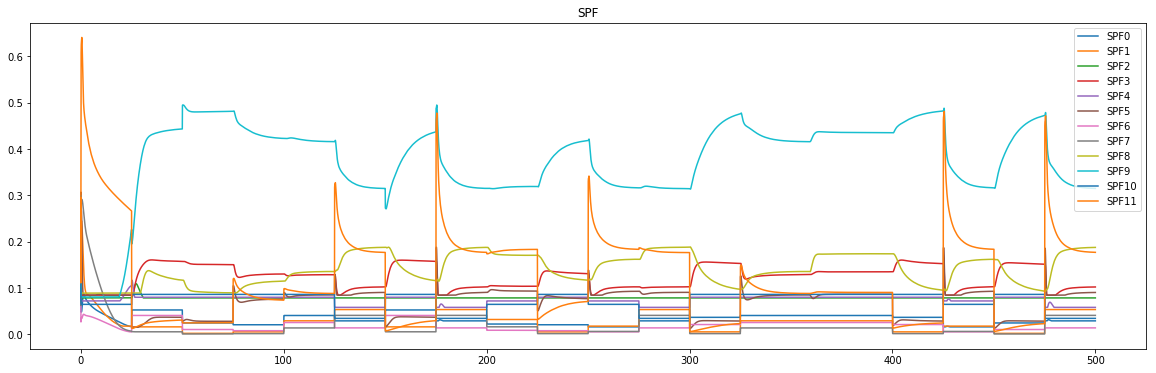

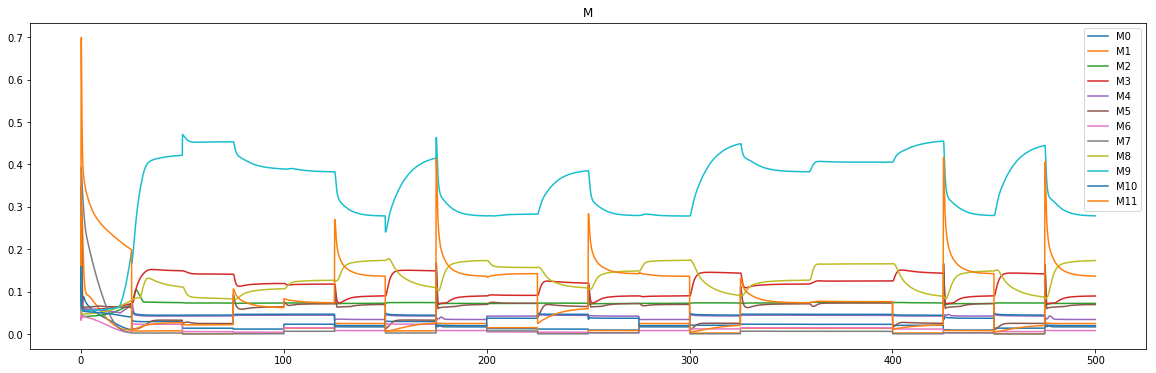

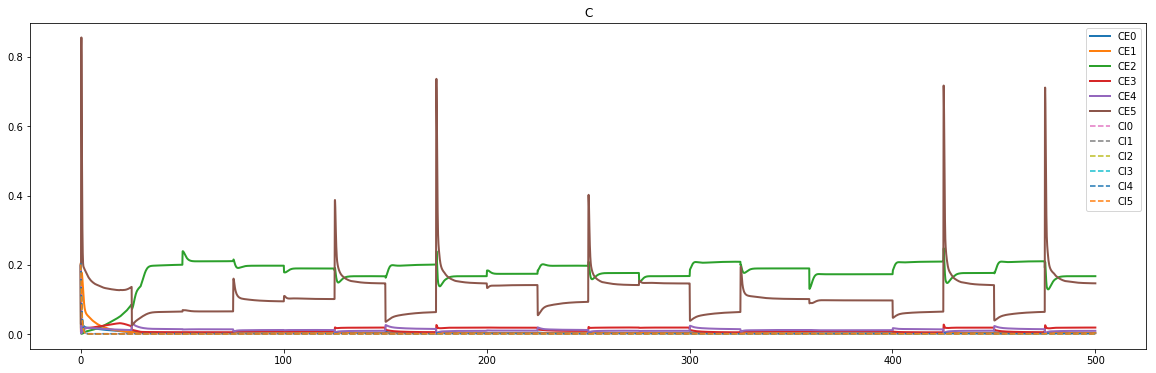

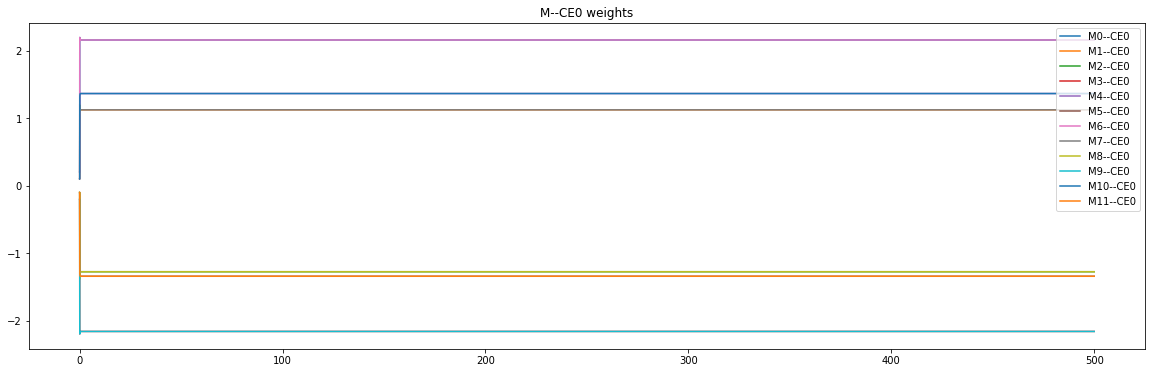

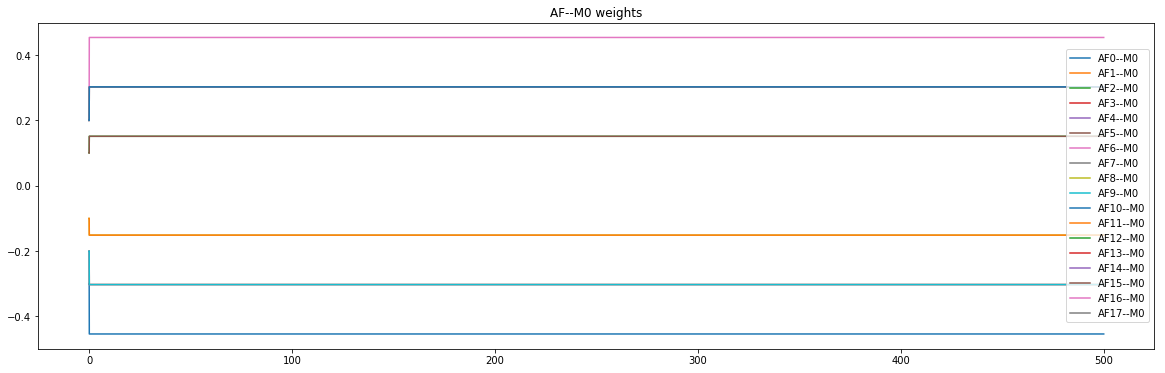

In [8]:
arm_activs = plant_data[P]
# SPF
fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
SPF_legends = ['SPF'+str(i) for i in range(len(SPF))]
plt.legend(SPF_legends)
plt.title('SPF')
print(SPF_data[:,-1])

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
M_legends = ['M'+str(i) for i in range(len(M))]
plt.legend(M_legends)
plt.title('M')
print(M_data[:,-1])

# C
C_fig = plt.figure(figsize=fs)
CE_data = np.array(data[CE])
CI_data = np.array(data[CI])
plt.plot(times, CE_data.transpose(), linewidth=2)
plt.plot(times, CI_data.transpose(), '--')
C_legends = ['CE'+str(i) for i in range(len(CE))]
C_legends += ['CI'+str(i) for i in range(len(CI))]
plt.legend(C_legends)
plt.title('C')

# M--CE0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_CE_track])
plt.plot(times, w_track_data.transpose())
M_CE0_legends = ['M'+str(i)+'--CE0' for i in range(len(M_CE_track))]
plt.legend(M_CE0_legends)
plt.title('M--CE0 weights')

# AF--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[AF_M0_track])
plt.plot(times, w_track_data2.transpose())
AF_M0_legends = ['AF'+str(i)+'--M0' for i in range(len(AF_M0_track))]
plt.legend(AF_M0_legends)
plt.title('AF--M0 weights')

plt.show()

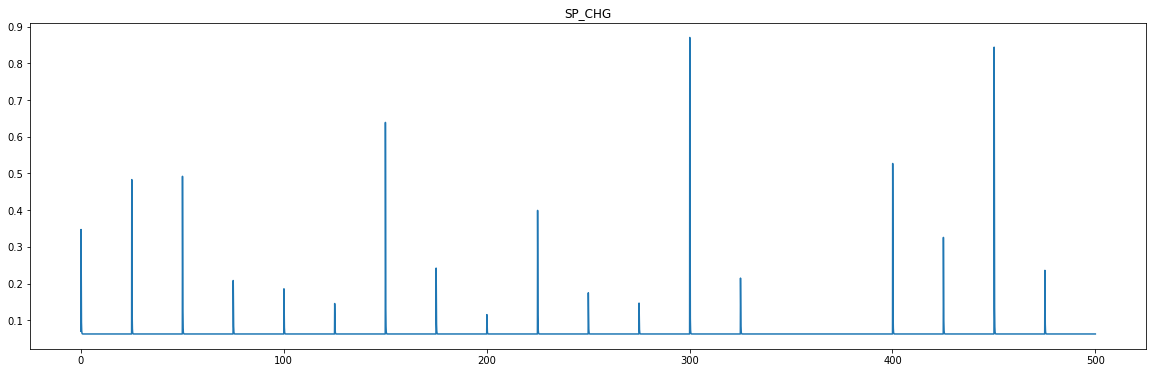

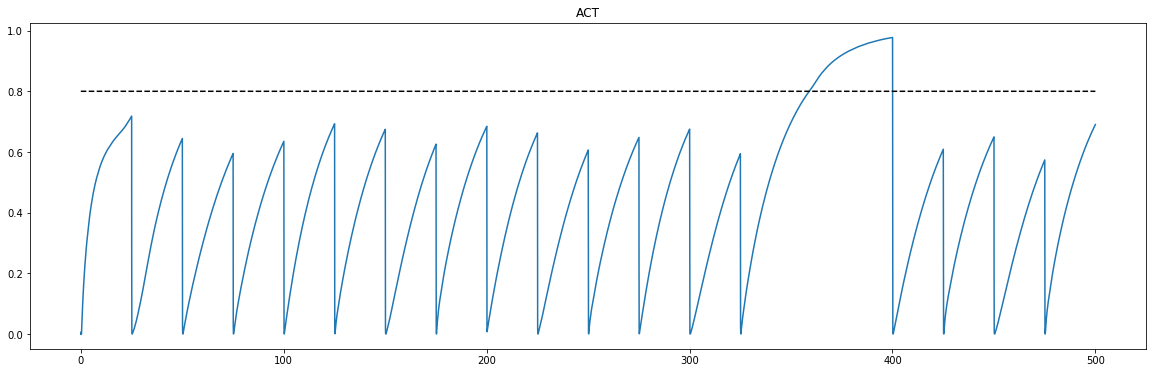

In [9]:
chg_fig = plt.figure(figsize=fs)
chg_data = np.array(data[SP_CHG])[0]
plt.plot(times, chg_data)
plt.title('SP_CHG')

act_fig = plt.figure(figsize=fs)
act_data = np.array(data[ACT])[0]
plt.plot(times, act_data)
plt.plot(times, 0.8*np.ones_like(times), 'k--')

plt.title('ACT')
plt.show()

shoulder angle: 1.001478, shoulder vel: 1.182401
AFe_data:
[3.46915730e-001 2.28305553e-001 4.09673014e-001 3.64370621e-001
 3.32568047e-001 3.15084429e-001 9.88131292e-323 9.38724727e-323
 9.88131292e-323 4.54022159e-003 9.38724727e-323 5.09197824e-003
 9.88131292e-323 9.88131292e-323 1.92268258e-002 3.61585932e-002
 9.38724727e-323 4.78770901e-002]
AFi_data:
[9.38724727e-323 0.00000000e+000 9.88131292e-323 9.88131292e-323
 0.00000000e+000 0.00000000e+000 9.88131292e-323 2.57054751e-001
 9.38724727e-323 9.88131292e-323 9.88131292e-323 9.38724727e-323
 0.00000000e+000 2.45479427e-001 0.00000000e+000 0.00000000e+000
 0.00000000e+000 9.38724727e-323]


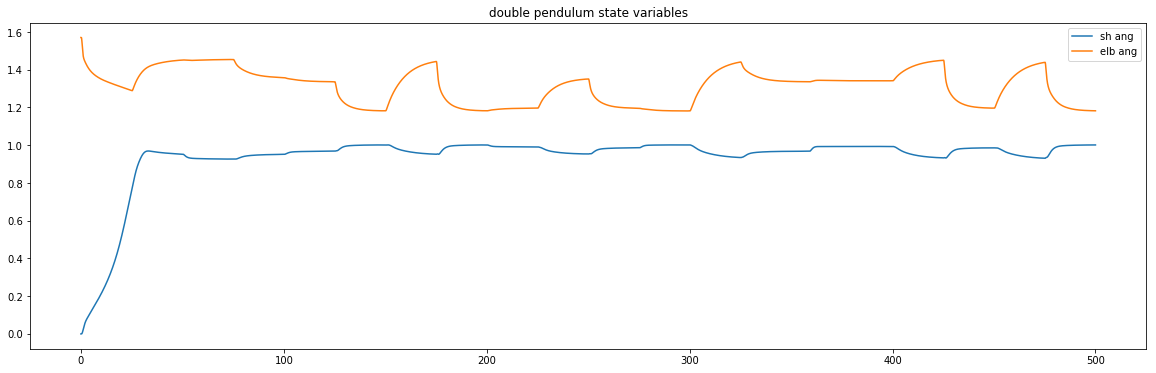

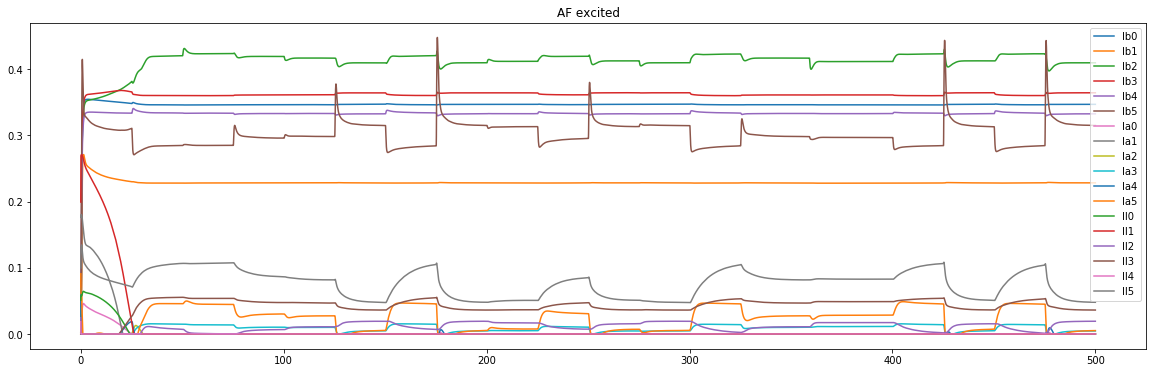

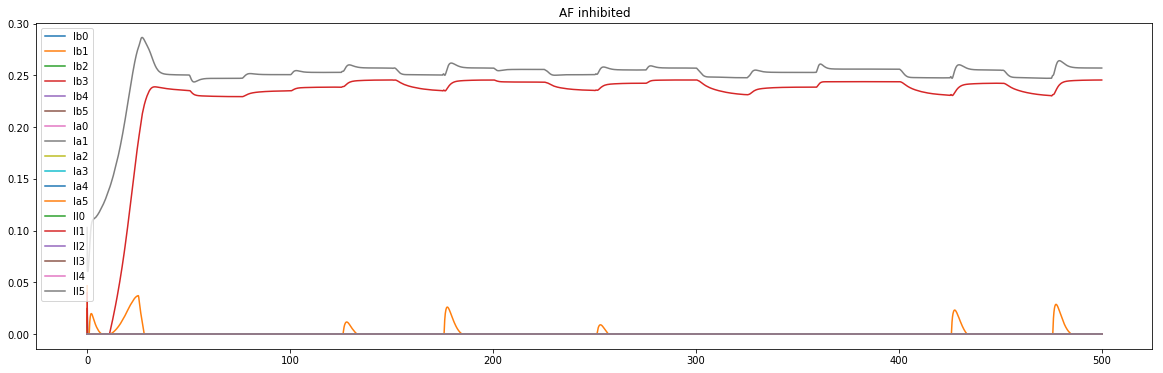

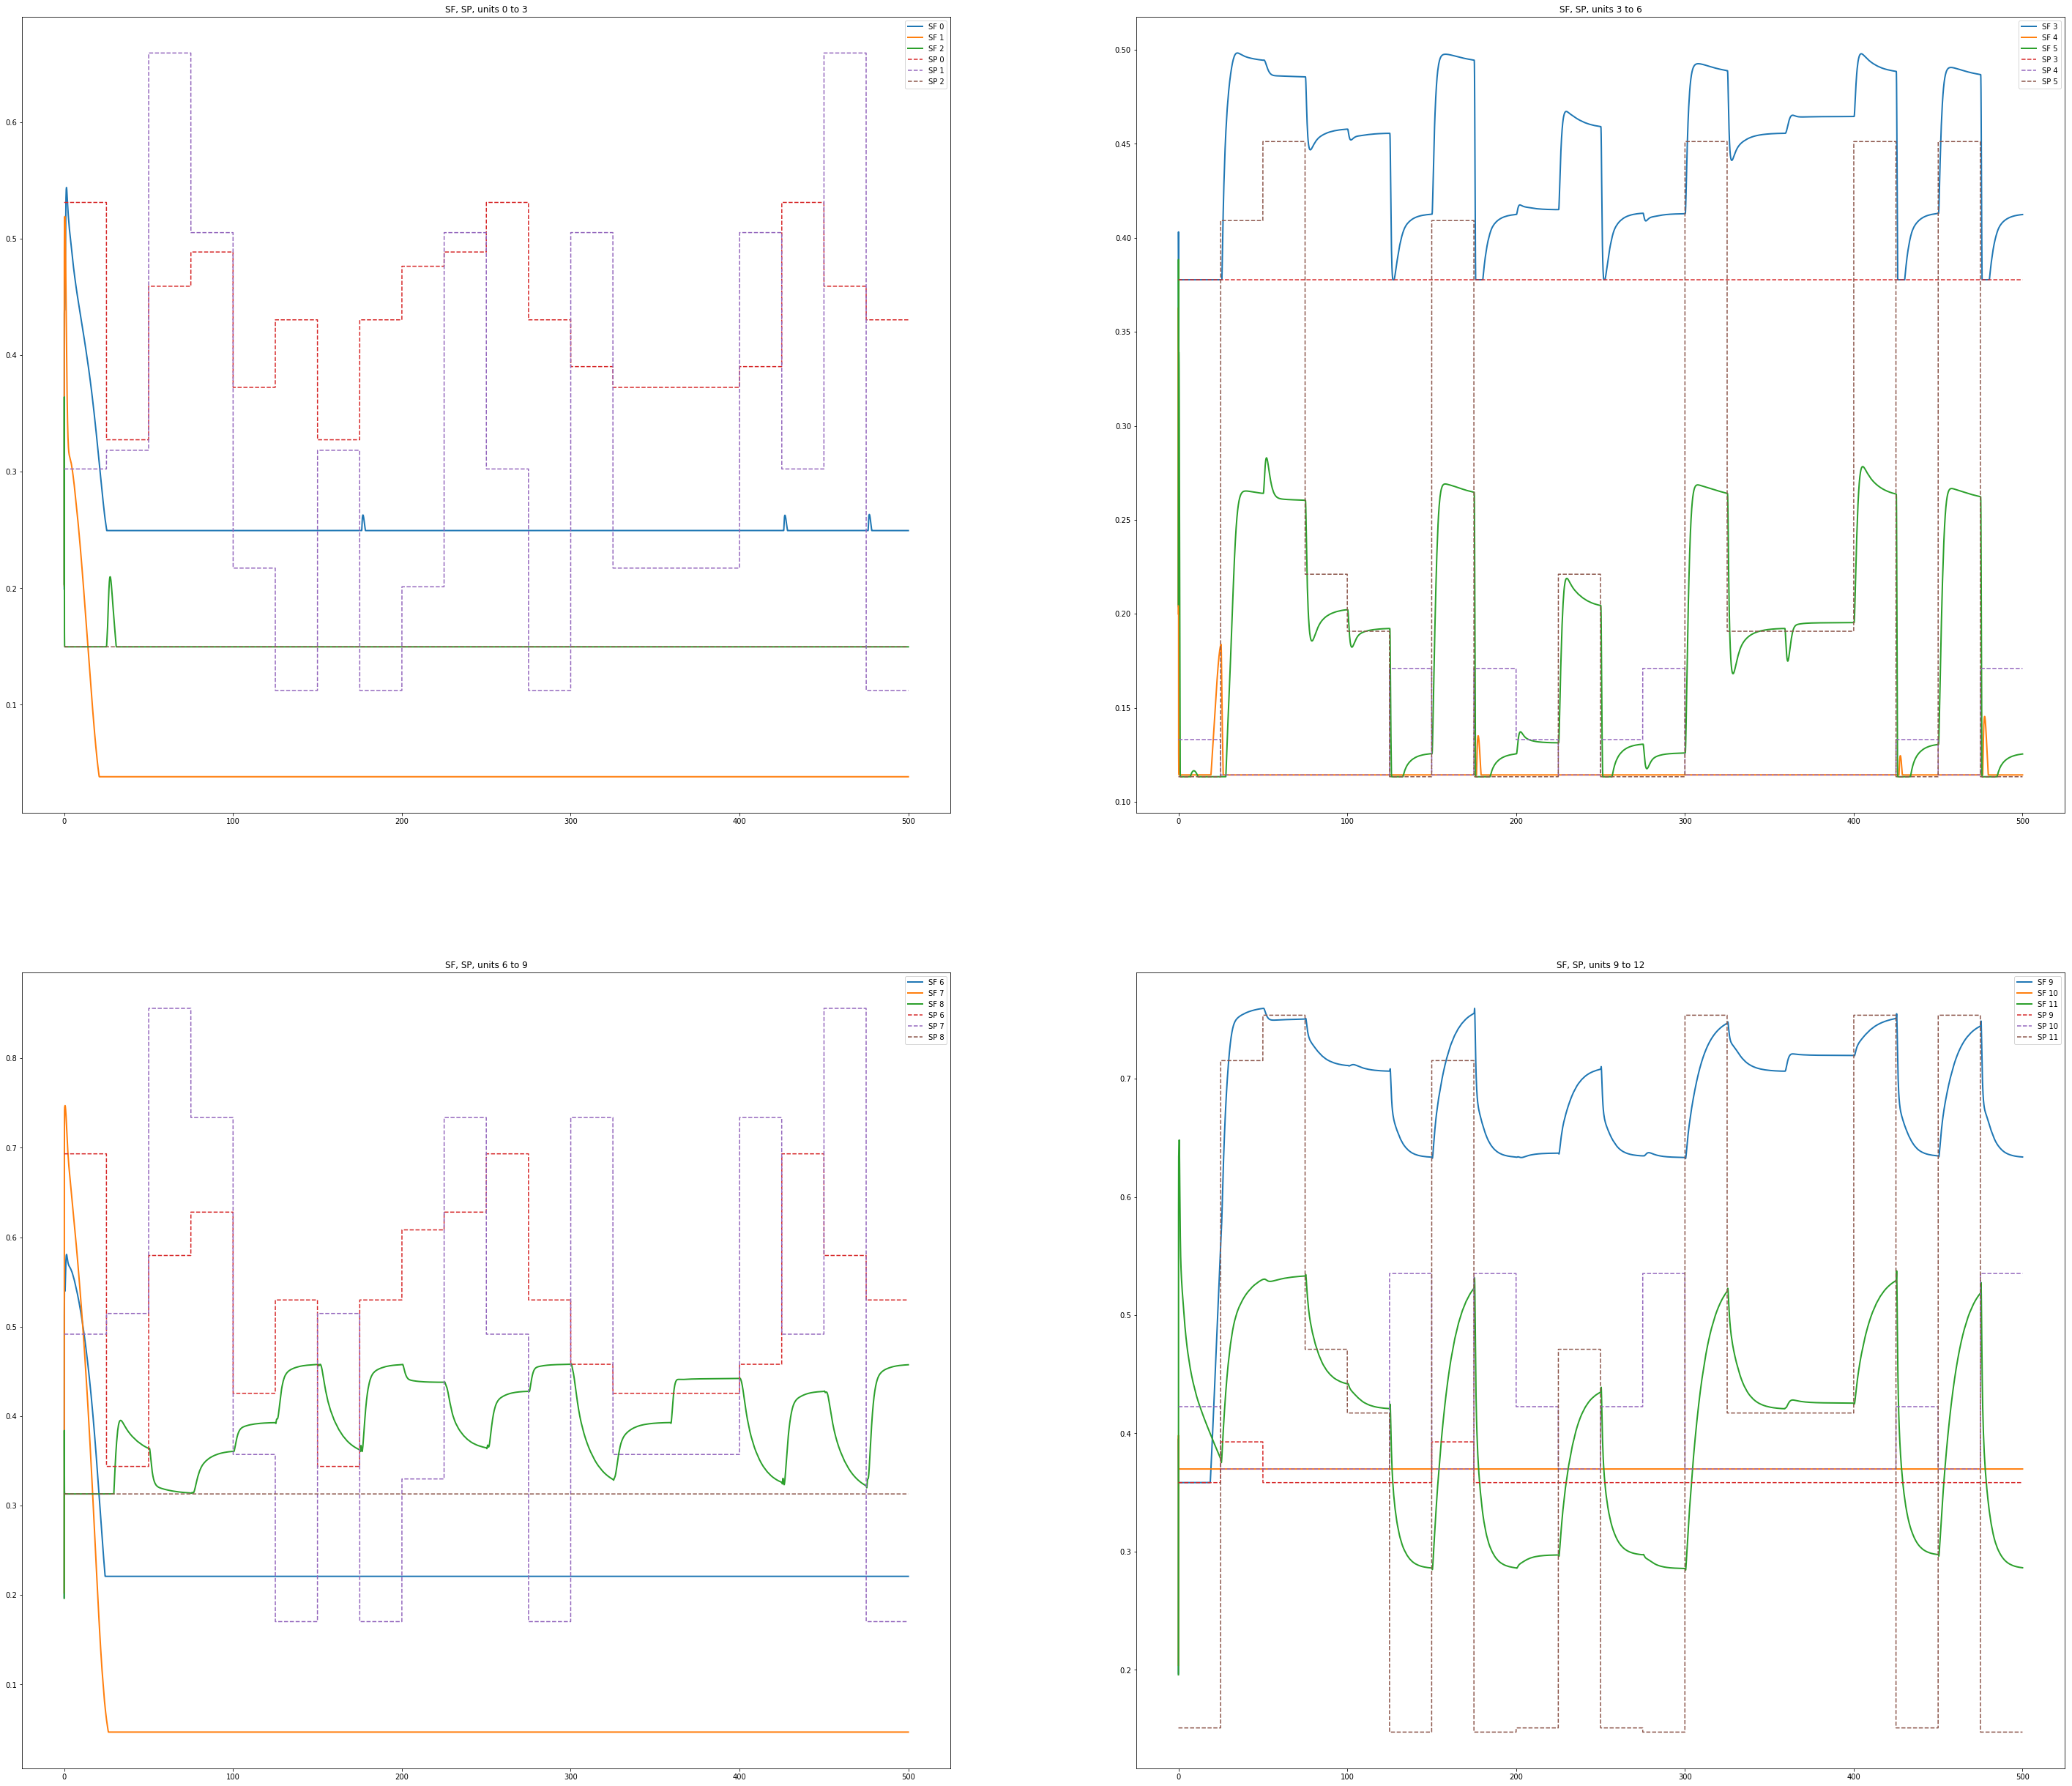

SF = 
[0.24949874 0.03811522 0.149688   0.41240764 0.11427232 0.12541778
 0.2209084  0.04682139 0.45741434 0.63378456 0.36986357 0.28631771]
SP = 
[0.43047519 0.11219529 0.149688   0.37770748 0.17095275 0.11331374
 0.52983429 0.17033139 0.31302909 0.35834032 0.5352408  0.14729043]


In [11]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

# SF, SP
fs_old = fs
fs=(50,20)
SF_fig, axs = plt.subplots(2, 2, figsize=(fs[0], 2.2*fs[1]))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
for row in range(2):
    for col in range(2):
        ax = axs[row][col]
        base = 3*col + 6*row
        ax.plot(times, SF_data[base:base+3, :].transpose(), linewidth=2)
        ax.plot(times, SP_data[base:base+3, :].transpose(), '--')
        ax.set_title('SF, SP, units %d to %d' % (base, base+3))
        SF_legends = ['SF '+ str(base+i) for i in range(3)]
        SP_legends = ['SP '+ str(base+i) for i in range(3)]
        ax.legend(SF_legends + SP_legends)

plt.show()
fs = fs_old
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

X=0


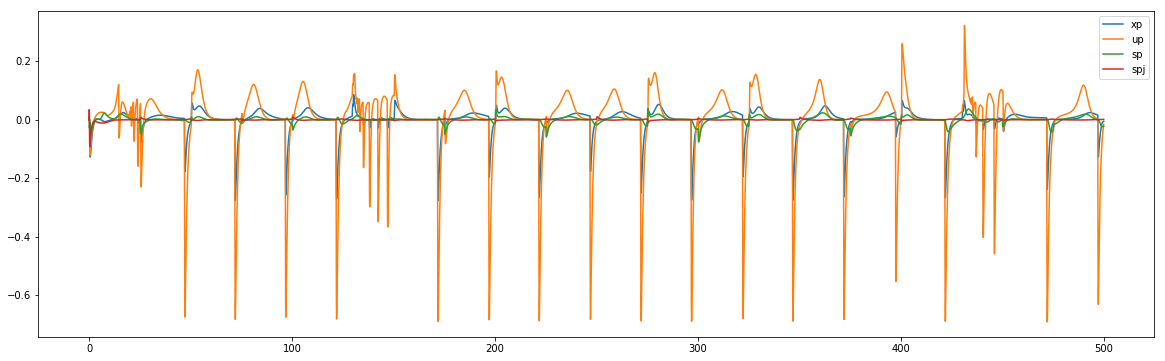

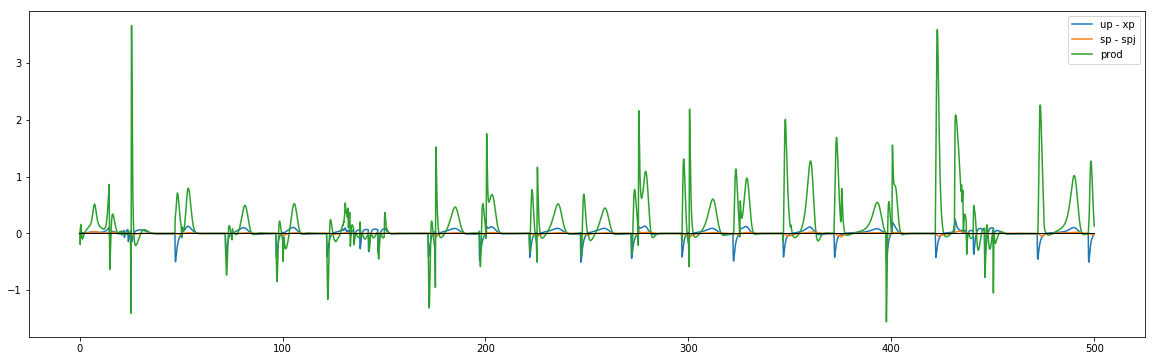

In [11]:
# plot all factors in the MX--C0 synaptic plasticity
print('X=%d' % (X))
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

AL_data:
[0.35463533 0.35821084 0.43428196 0.36333114 0.35970561 0.42405101]


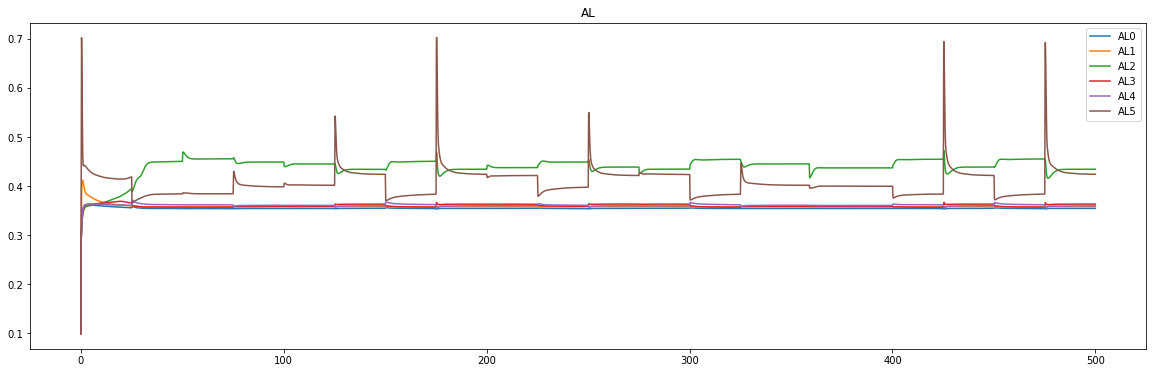

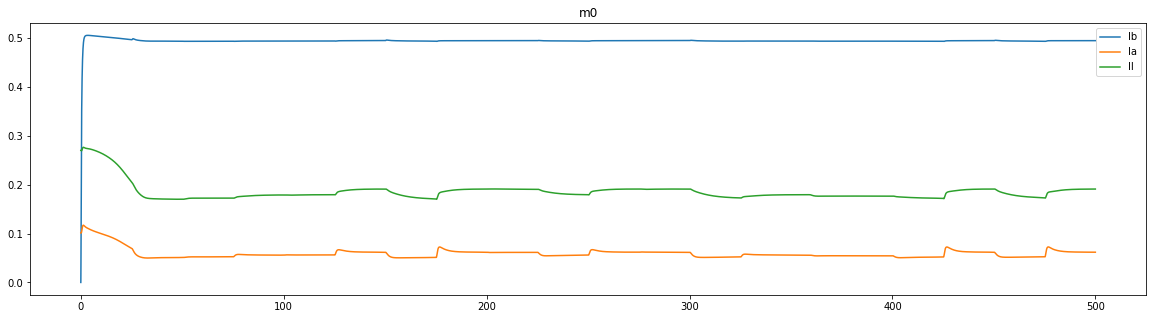

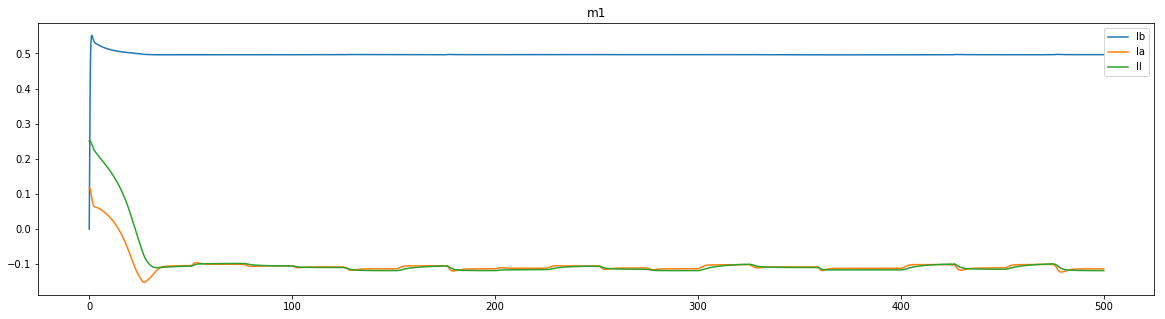

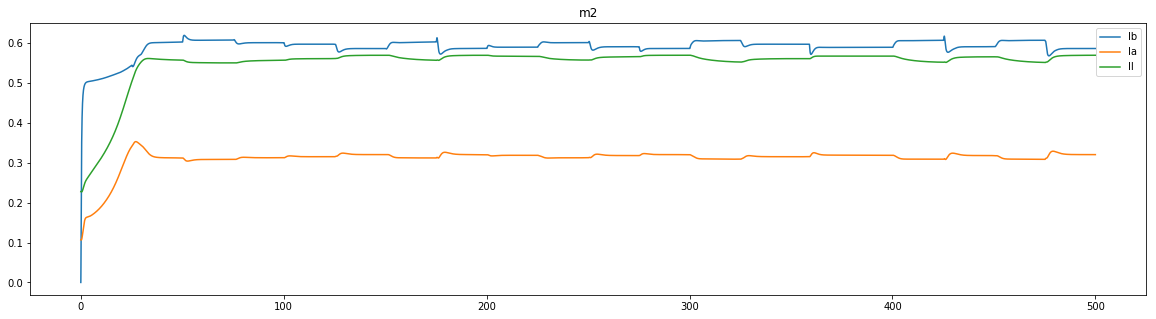

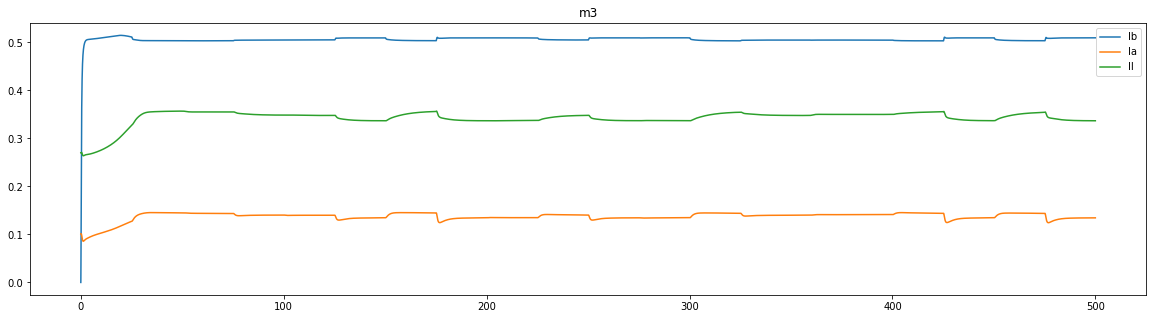

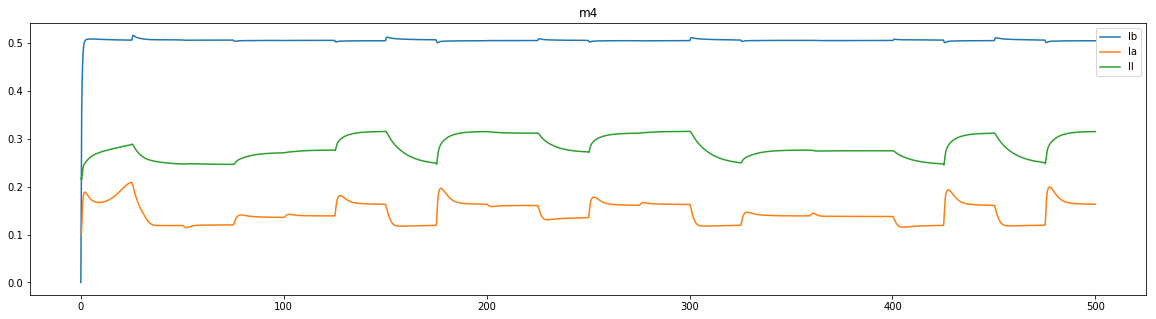

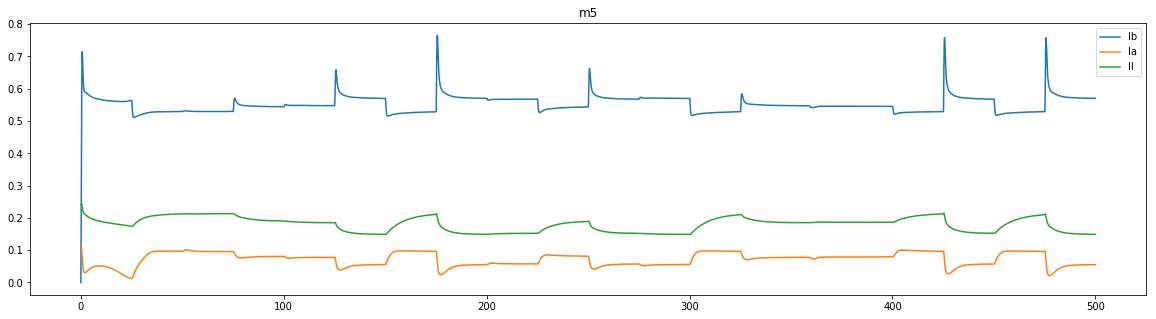

In [12]:
# Alpha units
AL_fig = plt.figure(figsize=fs)
AL_data = np.array(data[AL])
plt.plot(times, AL_data.transpose())
AL_legends = ['AL'+str(i) for i in range(len(AL))]
plt.legend(AL_legends)
plt.title('AL')
print('AL_data:')
print(AL_data[:,-1])

# plotting muscle outputs
fs = (20,5)
legs = ['Ib', 'Ia', 'II']

for i in range(6):
    next_fig = plt.figure(figsize=fs)
    Ib = arm_activs[:,22+i]
    Ia = arm_activs[:,28+i]
    II = arm_activs[:,34+i]
    plt.plot(times, Ib, times, Ia, times, II)
    #plt.plot(times, Ib)
    plt.legend(legs)
    plt.title('m' + str(i))
plt.show()

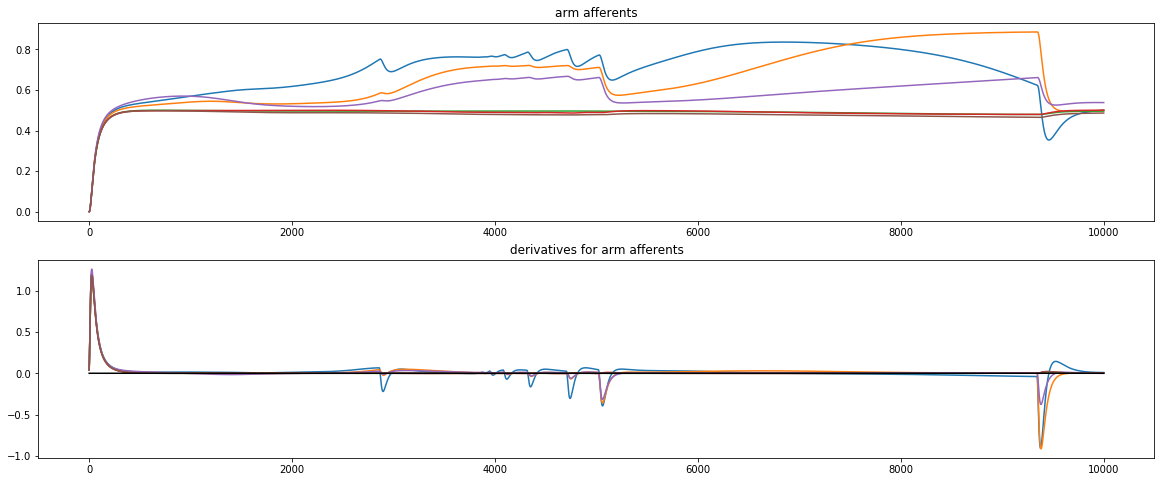

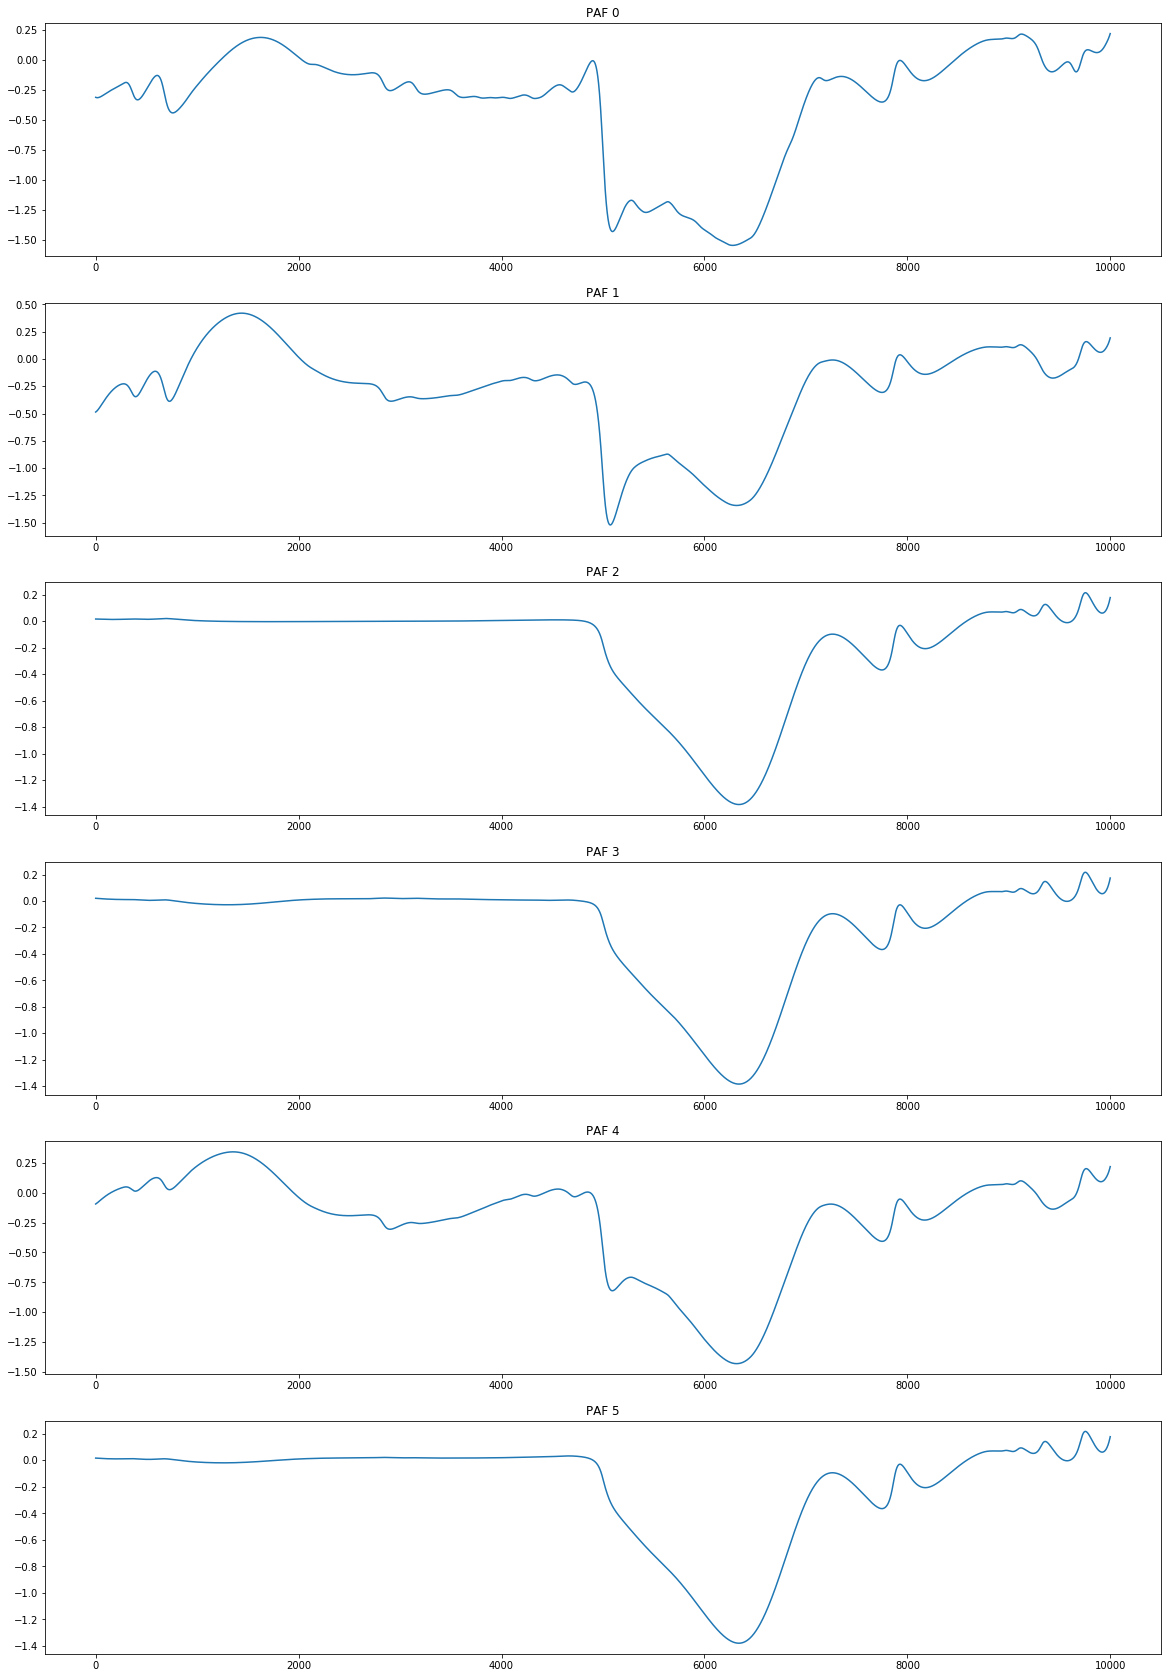

In [13]:
# ANALYSIS OF CORRELATIONS BETWEEN ARM AFFERENTS

# obtaining arm afferents and their derivatives
n_points = 10000
PAF = arm_activs[:n_points, 22:28] # tension afferents directly from arm
PAF_diff = np.gradient(PAF, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(PAF)
axs[0].set_title('arm afferents')
axs[1].plot(PAF_diff)
axs[1].set_title('derivatives for arm afferents')
axs[1].plot(np.zeros(PAF_diff.shape[0]), 'k')

# comparing some signals
#fig, axs = plt.subplots(2, 1, figsize=(20, 8))
#axs[0].plot(PAF[:,6], 'b', PAF[:,14], 'r')
#axs[1].plot(PAF[:,6], 'b', PAF[:,10], 'r')

# plotting the correlation of one signal against all others
Ia_0 = arm_activs[:n_points, 28]
Ia_0_diff = np.gradient(Ia_0) / net.min_delay
corr_fig, corr_axs = plt.subplots(6, 1, figsize=(20,30))
for row in range(6):
    corr = np.correlate(Ia_0_diff, PAF_diff[:, row], mode='same')
    corr_axs[row].plot(corr)
    #corr_axs[row].set_ylim([-100,100])
    corr_axs[row].set_title('PAF ' + str(row))
plt.show()

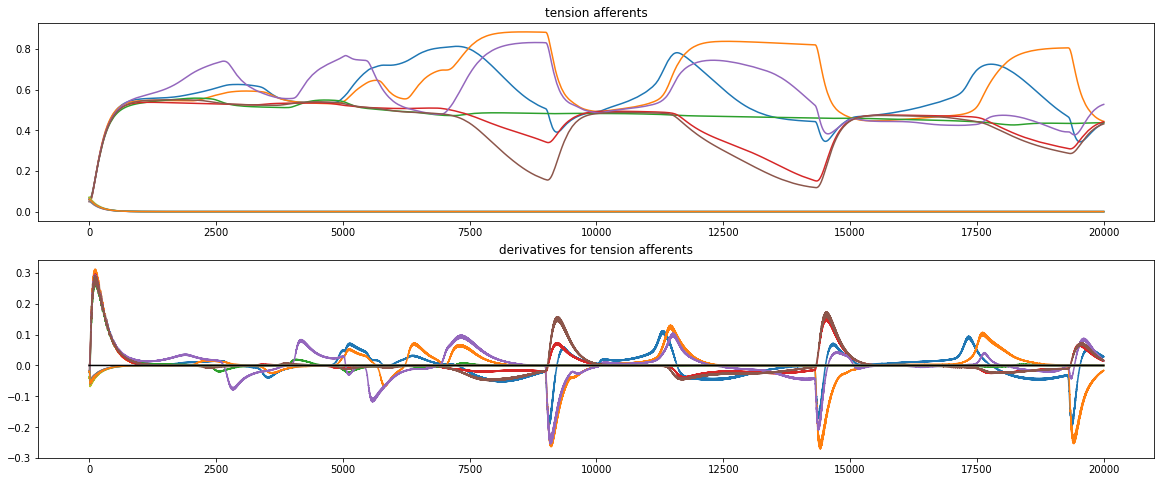

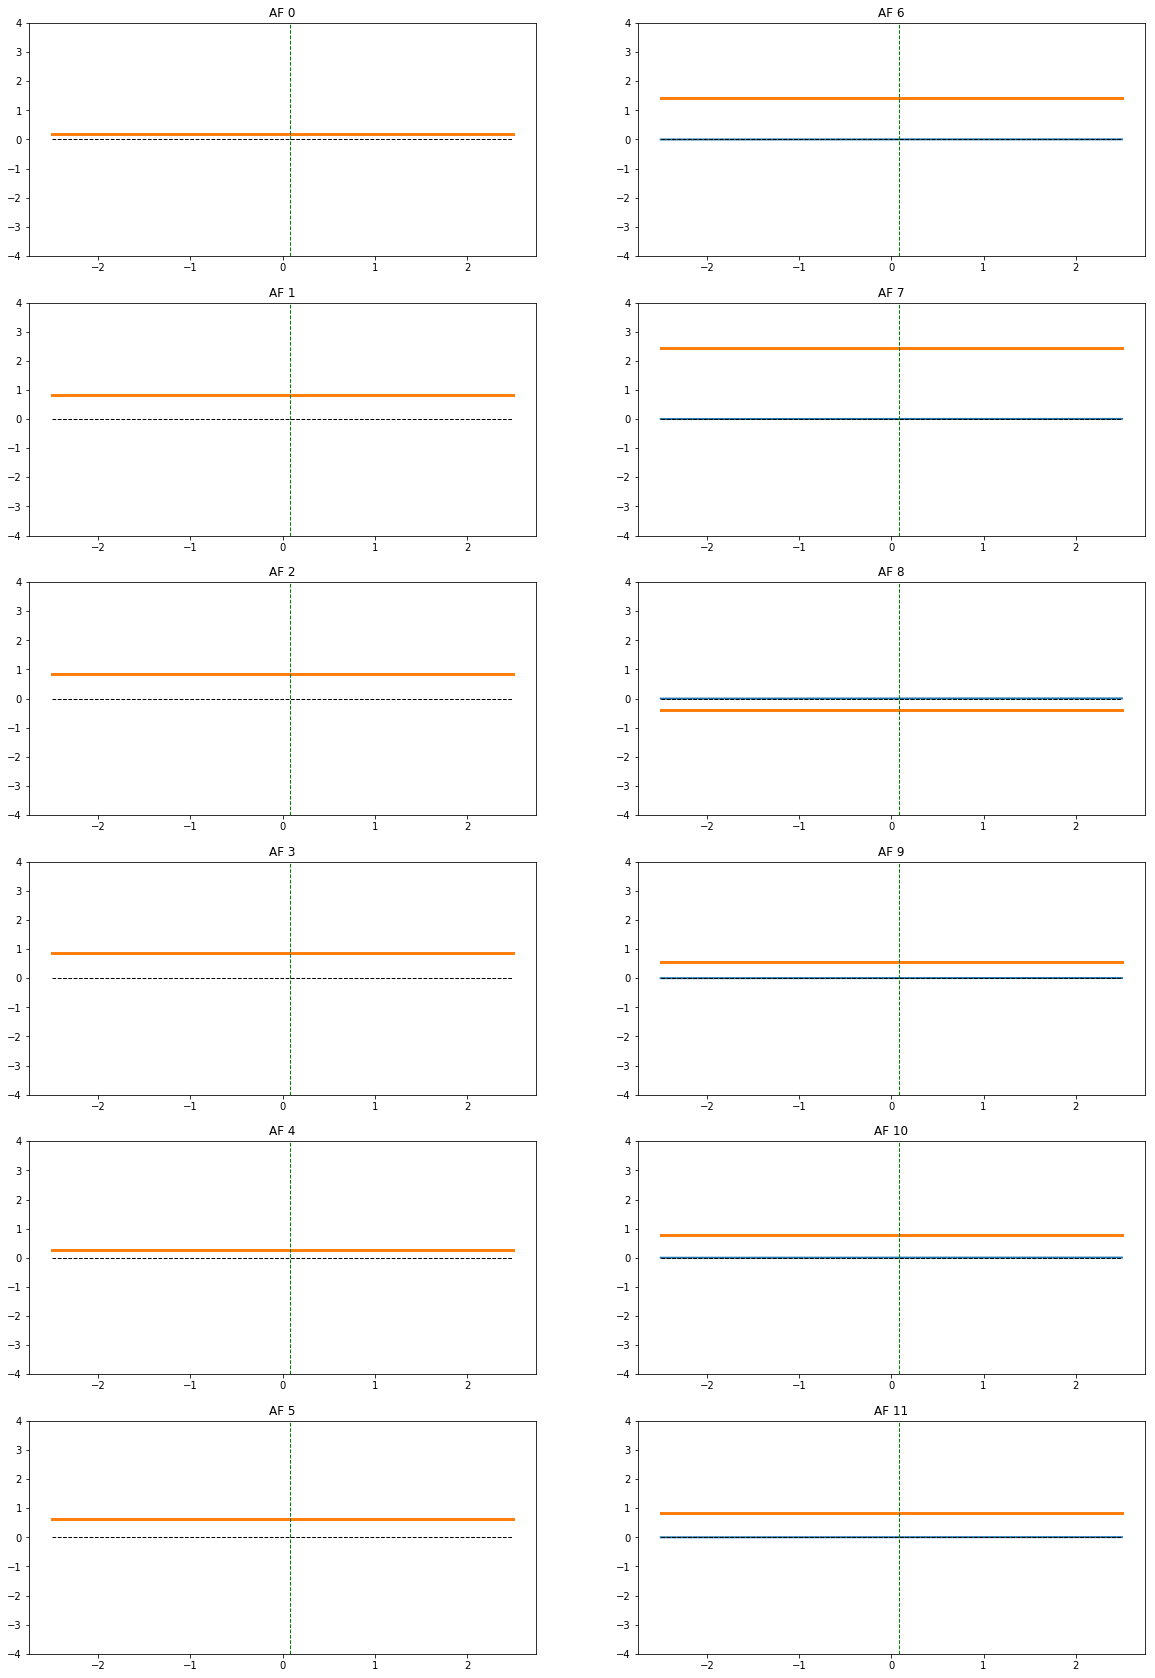

In [19]:
# ANALYSIS OF CORRELATIONS BETWEEN AFFERENT UNITS 
##############################
### NON-NORMALIZED VERSION ###
##############################
# obtaining arm afferents and their derivatives
n_points = 20000
AFD = data[AF[0:6]+AF[18:24], :n_points].transpose() # tension afferents
AFD_diff = np.gradient(AFD, axis=0) / net.min_delay
fig, axs = plt.subplots(2, 1, figsize=(20, 8))
axs[0].plot(AFD)
axs[0].set_title('tension afferents')
axs[1].plot(AFD_diff)
axs[1].set_title('derivatives for tension afferents')
axs[1].plot(np.zeros(AFD_diff.shape[0]), 'k')

# comparing some signals
#fig, axs = plt.subplots(2, 1, figsize=(20, 8))
#axs[0].plot(AFD[:,6], 'b', AFD[:,14], 'r')
#axs[1].plot(AFD_diff[:,6], 'b', AFD[:,10], 'r')

# plotting the correlation of one signal against all others
Ia_0 = arm_activs[:n_points, 28]  # The signal we'll compare
Ia_0_diff = np.gradient(Ia_0) / net.min_delay
AF__M0_w = [syn.w for syn in net.syns[M[0]] if syn.preID in AF[0:6]+AF[18:24]]
corr_fig, corr_axs = plt.subplots(6, 2, figsize=(20,30))
mid = int(round(AFD.shape[0]/2.)) # middle index for the signal (where 0 is)
span = min(500, mid)   # span to plot for the correlation
t = np.linspace(-span*net.min_delay, span*net.min_delay, 2*span)
x = t[int(len(t)/2)+AF__M_syn['extra_steps']] # the point approached by the plasticity rule
max_c = 4
min_c = -4
des_val_idx = mid + AF__M_syn['extra_steps']
lw = 2 # linewidth
for col in range(2):
    for row in range(6):
        cur_idx = 6*col + row
        corr = np.correlate(Ia_0_diff, AFD[:,cur_idx], mode='same')
        corr_axs[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs[row,col].set_ylim([min_c,max_c])
        corr_axs[row,col].plot(t, 1.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        corr_axs[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs[row,col].set_title('AF ' + str(cur_idx))
plt.show()

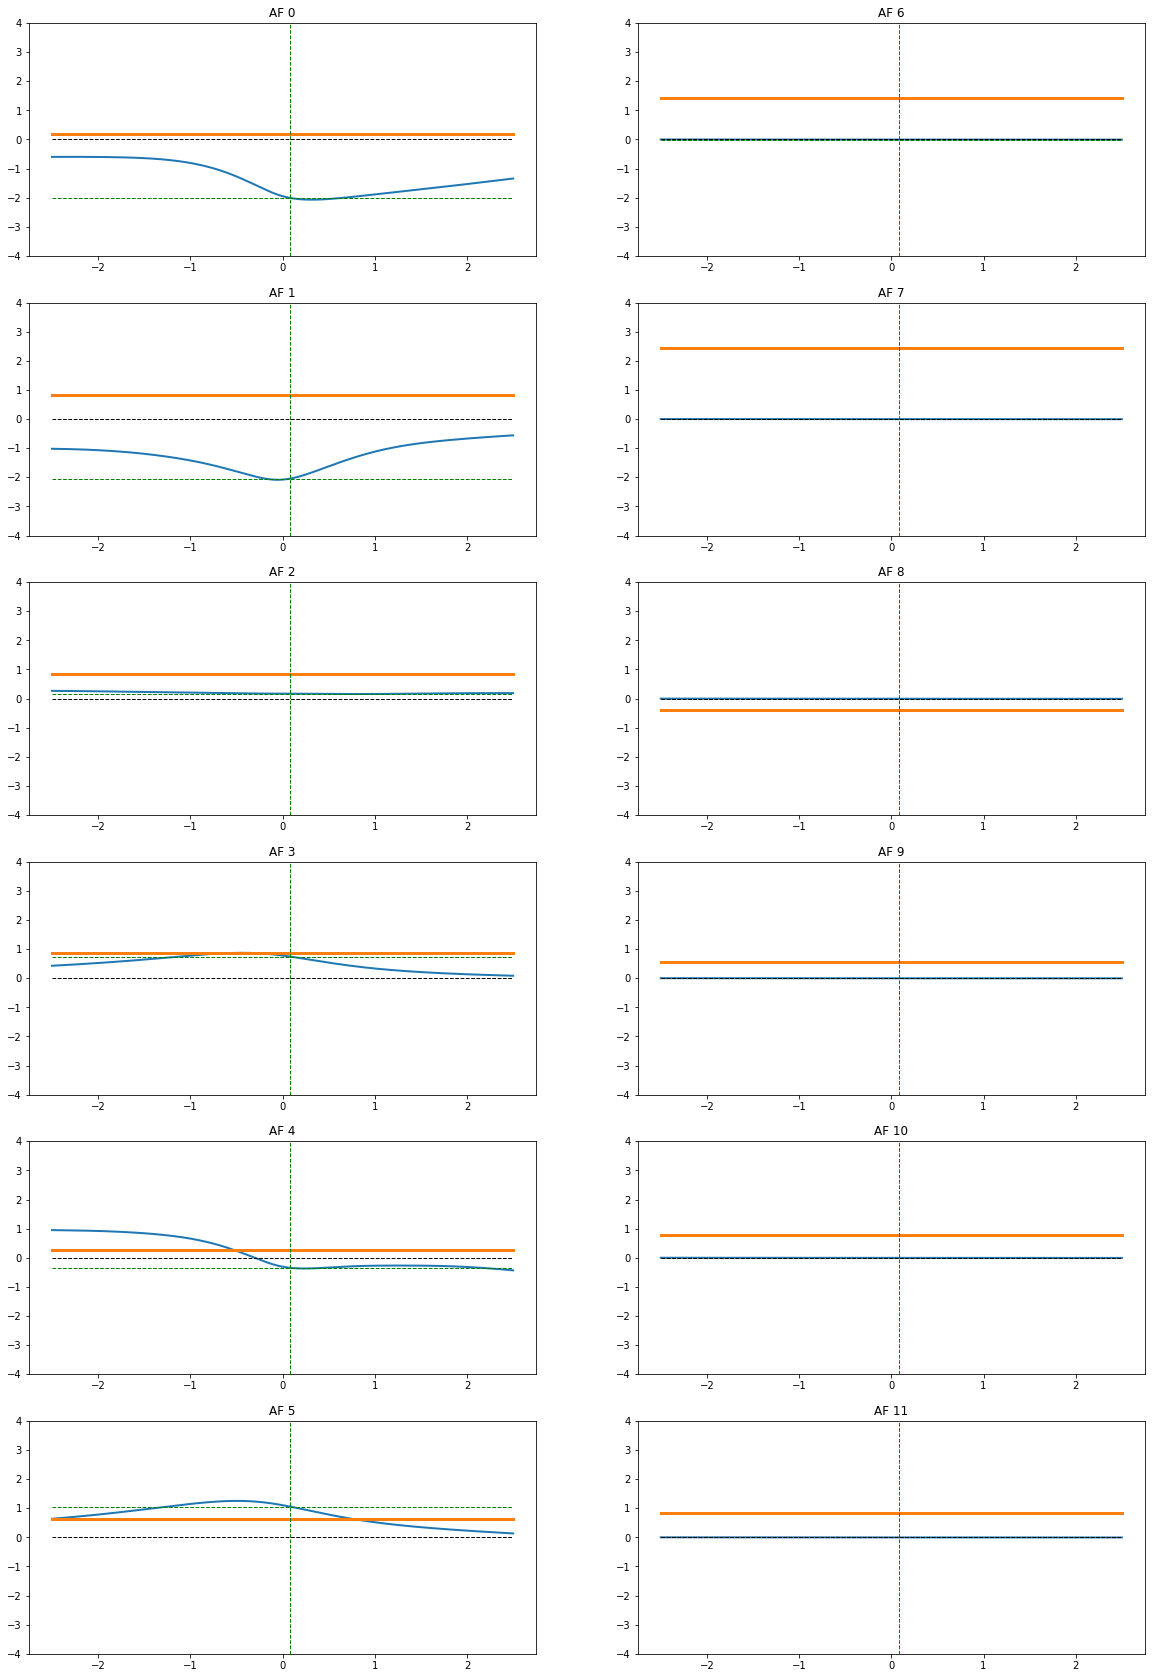

In [20]:
# plotting AF_diff VS AF_diff instead of AF_diff VS AF, to see if 
# the correlations are more informative
corr_fig2, corr_axs2 = plt.subplots(6, 2, figsize=(20,30))
for col in range(2):
    for row in range(6):
        cur_idx = 6*col + row
        corr = np.correlate(Ia_0_diff, AFD_diff[:,cur_idx], mode='same')
        corr_axs2[row,col].plot(t, corr[mid-span:mid+span], linewidth=lw)
        corr_axs2[row,col].set_ylim([min_c,max_c])
        corr_axs2[row,col].plot(t, 1.*AF__M0_w[cur_idx]*np.ones(len(t)), linewidth=3)
        corr_axs2[row,col].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        corr_axs2[row,col].plot([x, x], [min_c, max_c], 'g--', linewidth=1)
        corr_axs2[row,col].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        corr_axs2[row,col].set_title('AF ' + str(cur_idx))
plt.show()

In [14]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


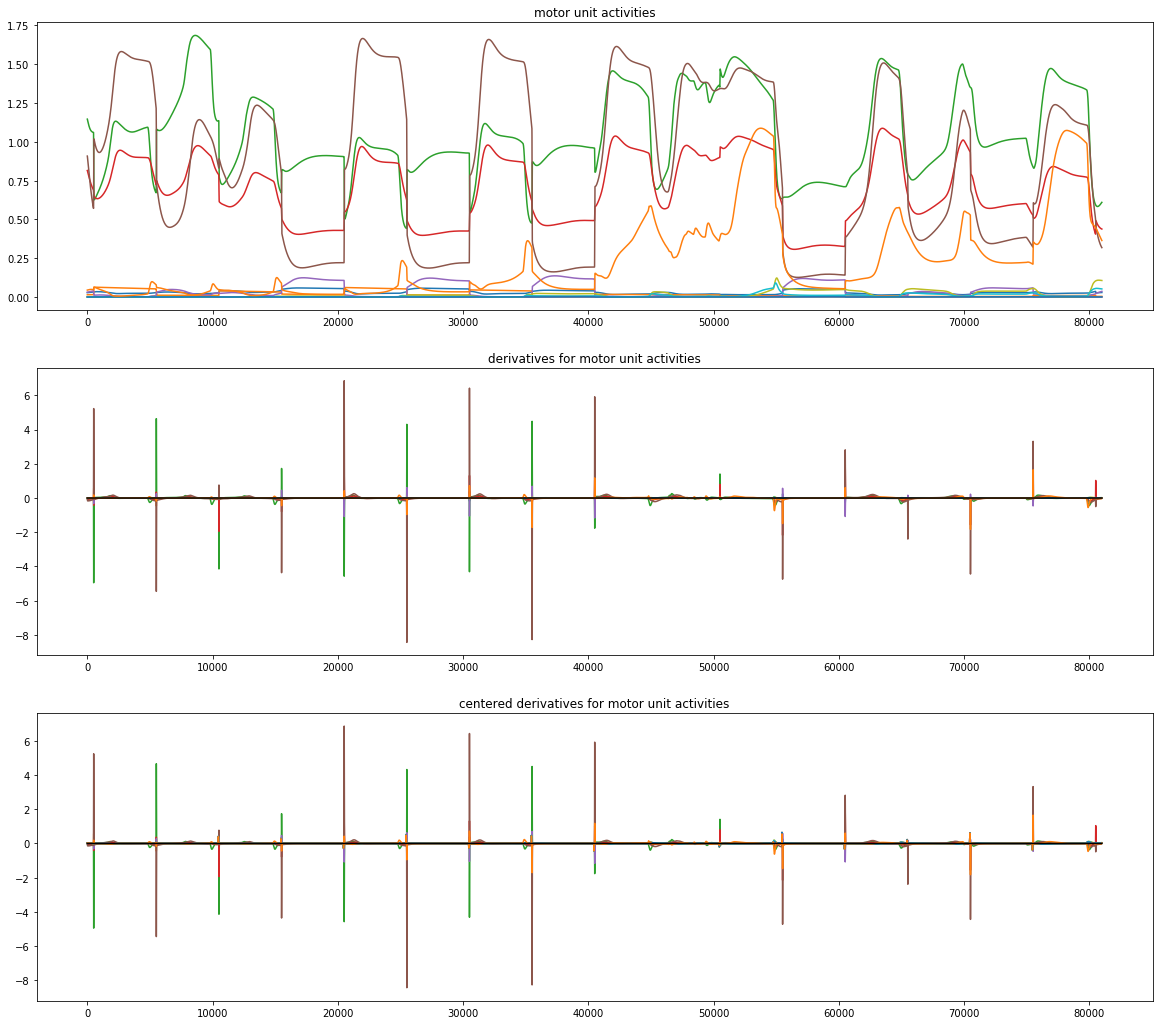

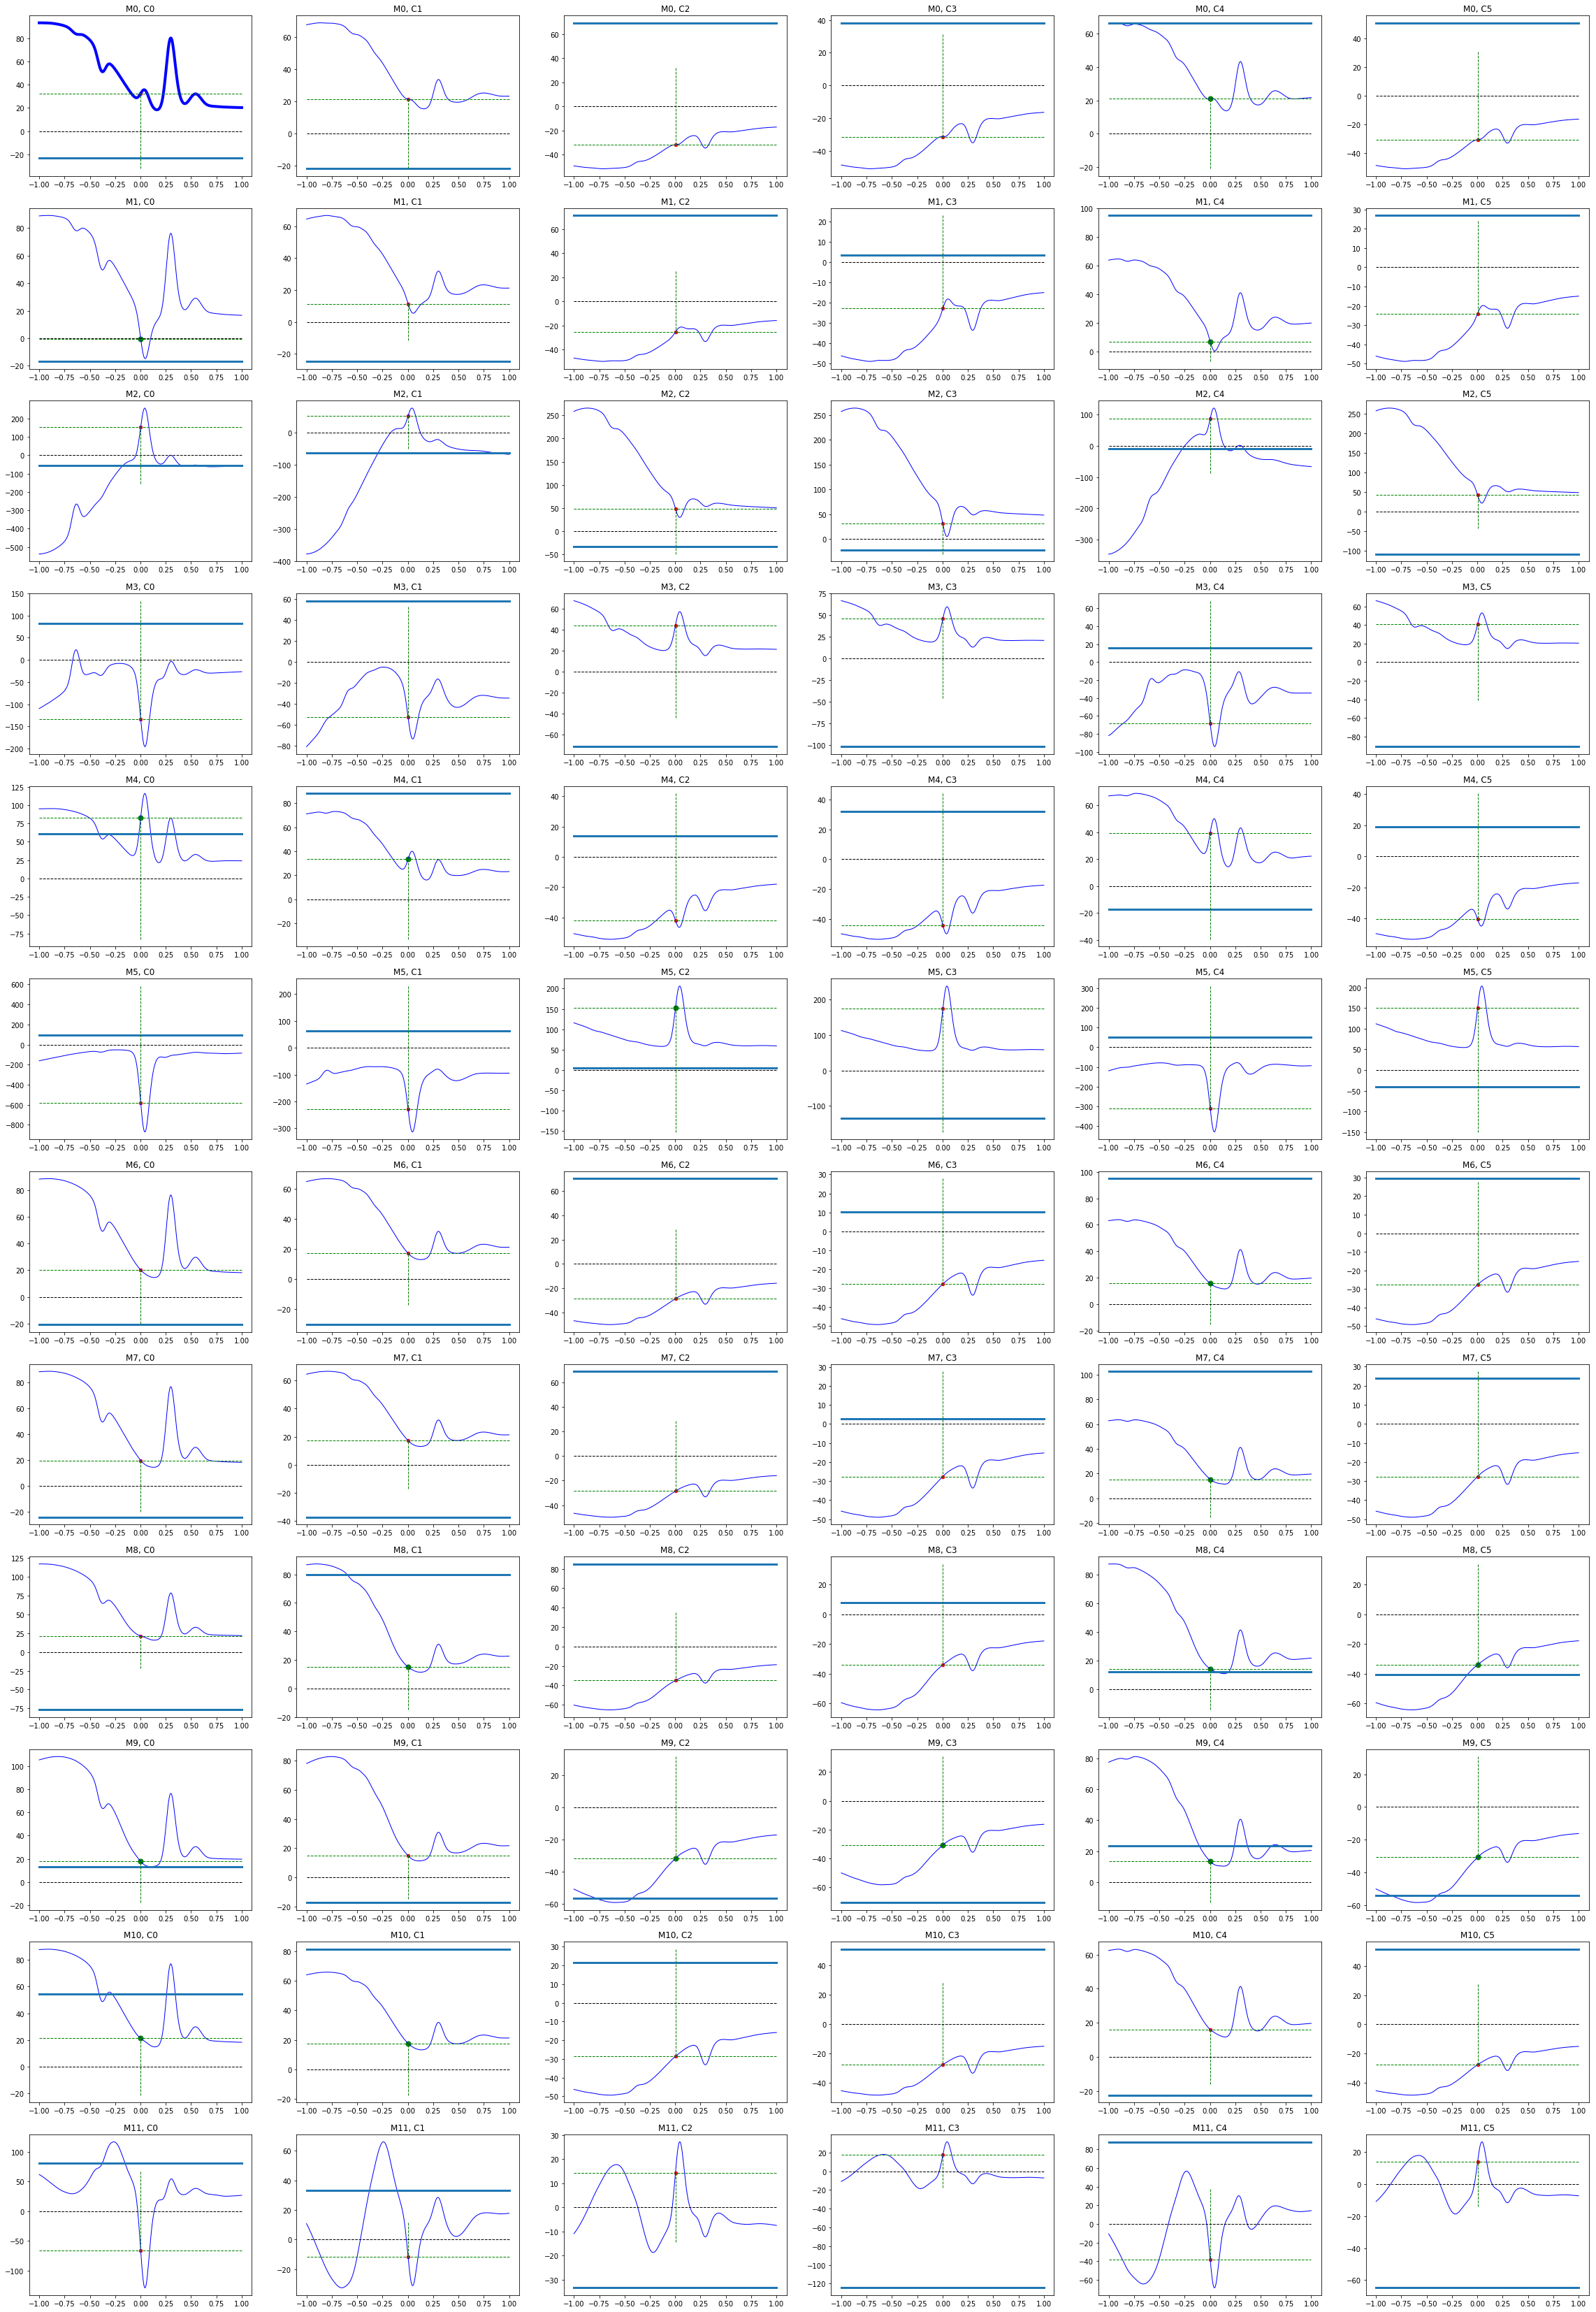

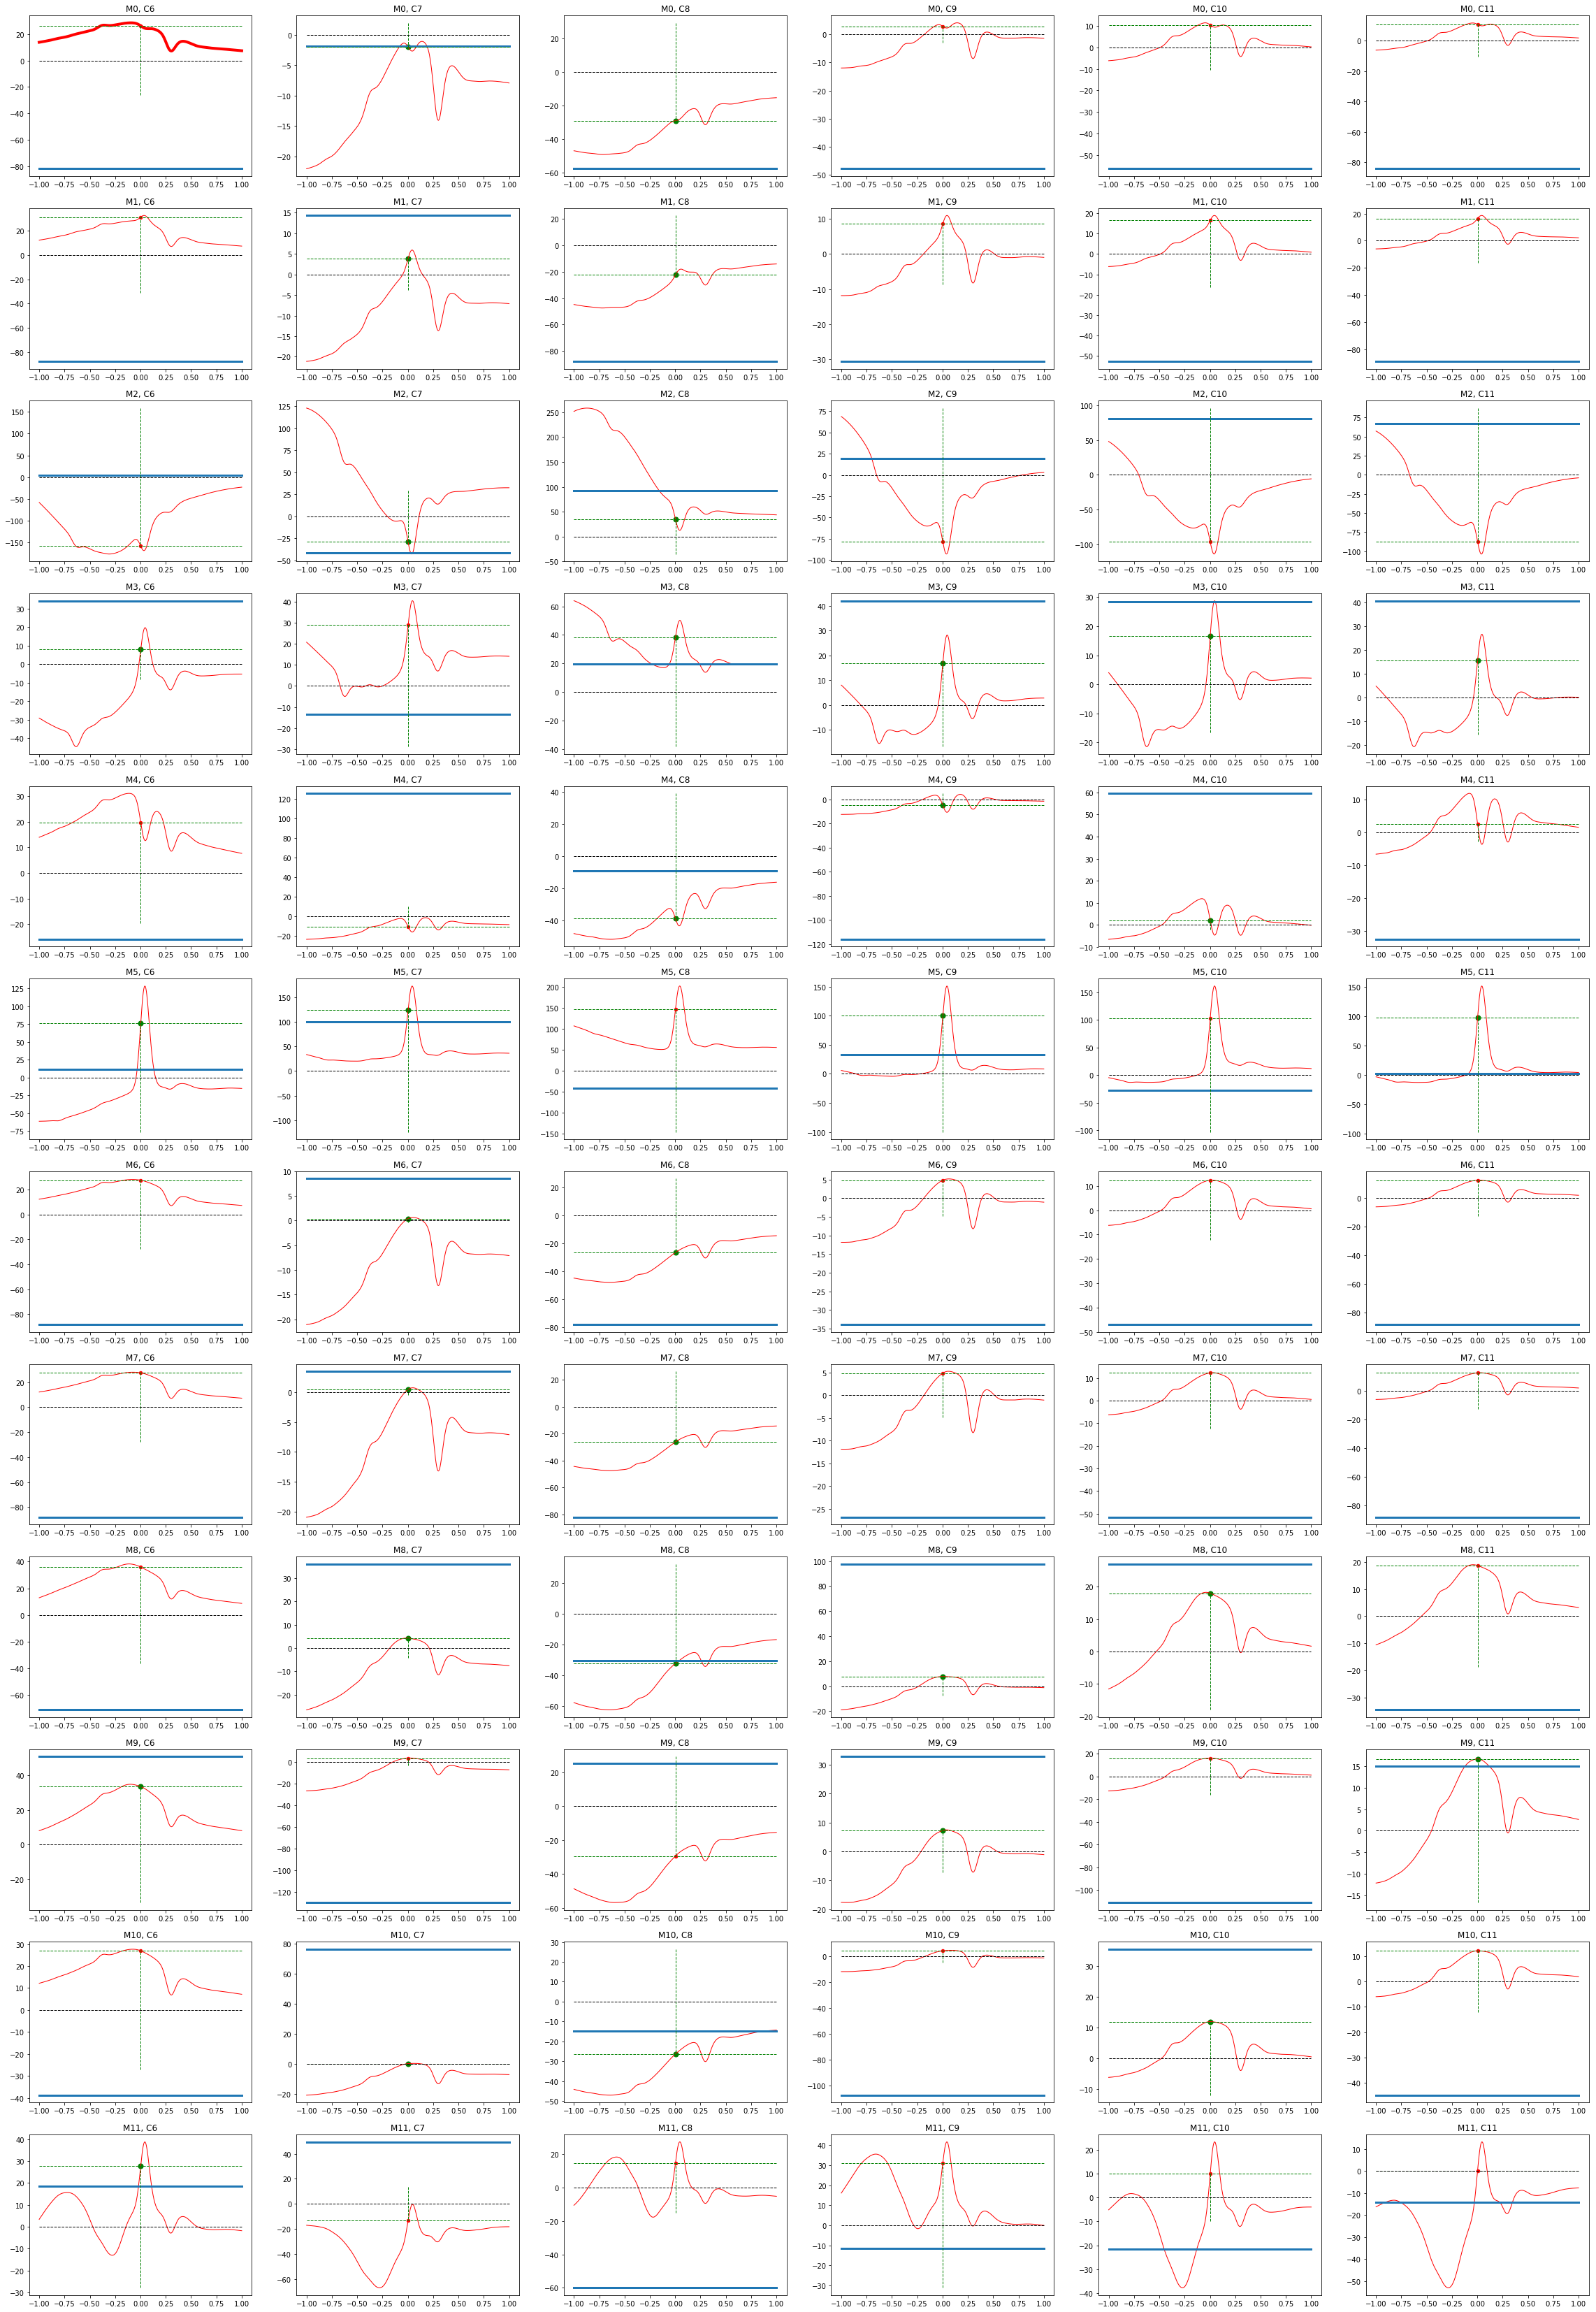

[[0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
[4. 3. 2. 1. 6. 2. 4. 8. 9. 5. 4. 3.]
[3. 4. 2. 5. 5. 5. 3. 3. 7. 8. 5. 1.]
0.3541666666666667
normalized M__CE correlation weight matrix:
[[ 5.16273399e-02, 8.67911149e-02, -1.68087708e-01, -1.54691607e-01
, 6.21535839e-02, -1.67473691e-01]
, [-6.03338190e-04, 4.60923708e-02, -1.32856020e-01, -1.12808677e-01
, 2.05651663e-02, -1.30857334e-01]
, [ 2.44853947e-01, 2.06628508e-01, 2.58185280e-01, 1.50861643e-01
, 2.61567636e-01, 2.31167384e-01]
, [-2.12111253e-01, -2.13876419e-01, 2.32751263e-01, 2.24633894e-01
, -2.03320533e-0

In [15]:
# ANALYSIS OF CORRELATIONS BETWEEN MOTOR UNITS AND C UNITS

# obtaining M,C unit activities and their derivatives
full_size = len(data[M[0]])
M_size = 81000 # number of points we will take from the M data signals
C_span = 40000 # number of points in half of the C data moving window
center_idx = int(round(full_size/2))
MD = data[M, center_idx-int(M_size/2):center_idx+int(M_size/2)].transpose()
#MD = data[M, -M_size:].transpose()
w_l = 31  # window length for smoothing
for idx in range(len(M)): # smoothing MD
    MD[:,idx] = smooth(MD[:,idx], window_len=w_l)[int(np.floor(w_l/2)):-int(np.floor(w_l/2))]
MD_diff = np.gradient(MD, axis=0) / net.min_delay
MD_diff_roll = np.roll(MD_diff, -CE_params['custom_inp_del'], axis=0) # delaying MD_diff
MD_diff_means = np.tile(np.mean(MD_diff_roll, axis=1), (12,1)).transpose()
MD_diff_center = MD_diff - MD_diff_means

CD = data[CE+CI, center_idx-C_span:center_idx+C_span].transpose()
CD_diff = np.gradient(CD, axis=0) / net.min_delay
#CD_diff_means = np.tile(np.mean(CD_diff, axis=1), (12,1)).transpose()
CD_diff_means = np.zeros((2*C_span,12))
for idx in range(12):
    CD_diff_means[:, idx] = np.mean(np.delete(CD_diff, np.s_[idx], axis=1), axis=1)
CD_diff_center = CD_diff - CD_diff_means

fig, axs = plt.subplots(3, 1, figsize=(20, 18))
axs[0].plot(MD)
axs[0].set_title('motor unit activities')
axs[1].plot(MD_diff)
axs[1].set_title('derivatives for motor unit activities')
axs[1].plot(np.zeros(MD_diff.shape[0]), 'k')
axs[2].plot(MD_diff_center)
axs[2].set_title('centered derivatives for motor unit activities')
axs[2].plot(np.zeros(MD_diff_center.shape[0]), 'k')

# plotting the correlation of one signal against all others
M__CE_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CE]
corr_figE, corr_axsE = plt.subplots(12, 6, figsize=(40,60))

M__CI_w = [[syn.w for syn in net.syns[c] if syn.preID in M] for c in CI]
corr_figI, corr_axsI = plt.subplots(12, 6, figsize=(40,60))

base_idx = 0 # index for positive Ia afferent for muscle 0
mid = int(round((M_size - 2*C_span)/2)) # index of the middle 0 shift value
plt_span = min(200, mid)   # span to plot for the correlation
t = np.linspace(-plt_span*net.min_delay, plt_span*net.min_delay, 2*plt_span)
eqs = np.zeros((12,12)) # matrix indicating whether weight and correlation have same sign
corr_w = np.zeros((12,12)) # what the weight should be, according to the correlation
des_val_idx = mid #+ CE_params['custom_inp_del']

for col in range(12):  # ranges through C units
    if col < 6:
        axes = corr_axsE
        weights = M__CE_w
        color='b'
    else:
        axes = corr_axsI
        weights = M__CI_w
        color='r'
    mcol = col%6
    for row in range(12):  # ranges through units
        cur_idx = 12*mcol+row
        if cur_idx == base_idx: lw = 4
        else: lw = 1
        corr = np.correlate(CD_diff_center[:,col], -MD_diff_center[:,row], mode='valid')
        axes[row,mcol].plot(t, corr[mid-plt_span:mid+plt_span], linewidth=lw, color=color)
        corr_w[row,col] = corr[des_val_idx]
        axes[row,mcol].plot(t, 100.*weights[mcol][row]*np.ones(len(t)), linewidth=3)
        axes[row,mcol].plot(t, corr[des_val_idx]*np.ones(len(t)), 'g--', linewidth=1)
        x = t[int(len(t)/2)] #+ CE_params['custom_inp_del']]
        axes[row,mcol].plot([x, x], [-corr_w[row,col], corr_w[row,col]], 'g--', linewidth=1)
        axes[row,mcol].plot(t, np.zeros(len(t)), 'k--', linewidth=1)
        axes[row,mcol].set_title('M' + str(row) + ', C' + str(col))
        # Finding if weights are following the correlations
        scat_s = 20
        scat_c = 'r'
        if np.sign(weights[mcol][row]) == np.sign(corr[des_val_idx]):
            eqs[row,col] = 1.
            scat_s = 50
            scat_c = 'g'
        axes[row,mcol].scatter([x], [corr[des_val_idx]], s=scat_s, c=scat_c)
plt.show()

# Regarding whether correlations and weights have the same sign
print(eqs)
print(np.sum(eqs, axis=0))
print(np.sum(eqs, axis=1))
print(sum(eqs.flatten())/(eqs.shape[0]*eqs.shape[1]))
# Regarding desired weights according to correlations
# normalizing columns of corr_w (weights on the same C unit)
n_corr_w = corr_w / np.linalg.norm(corr_w, axis=0)
import re
print('normalized M__CE correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,:6]))))
print('normalized M__CI correlation weight matrix:')
print(re.sub('\[,', '[', re.sub('\ +', ', ', str(n_corr_w[:,6:]))))

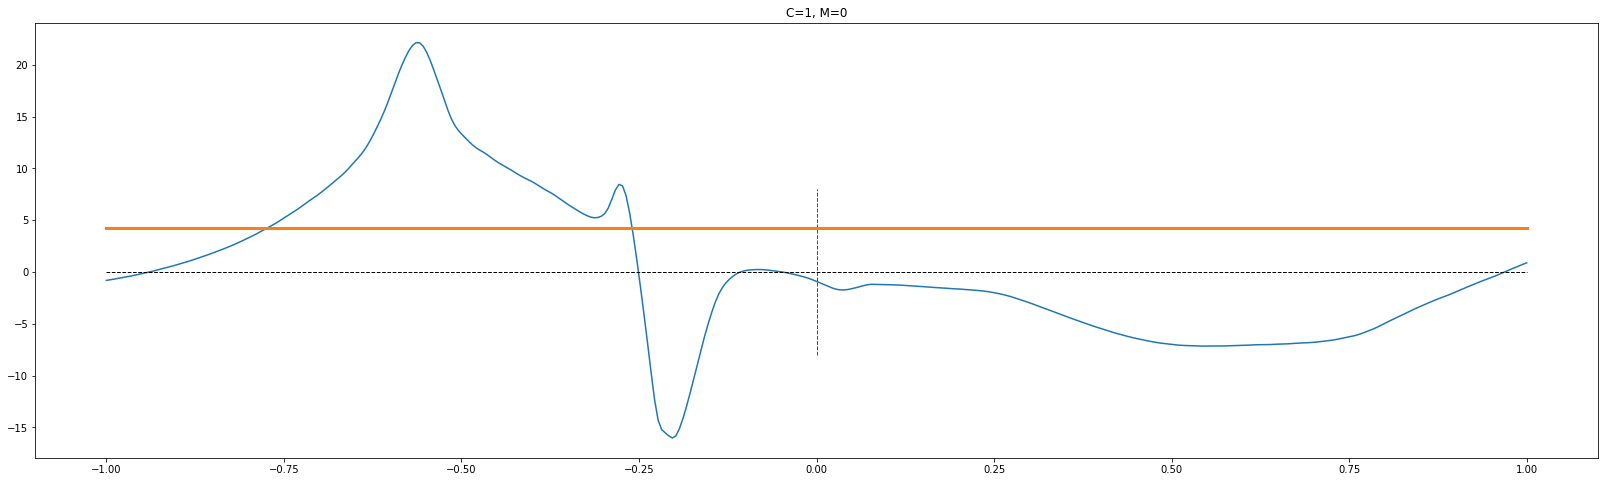

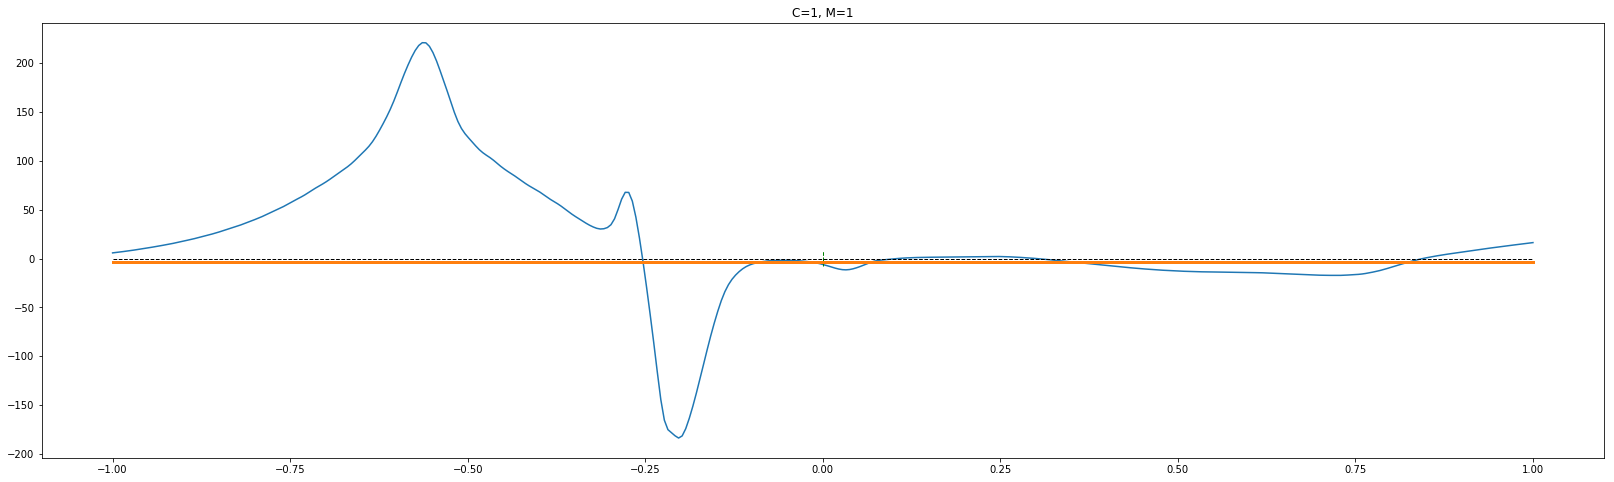

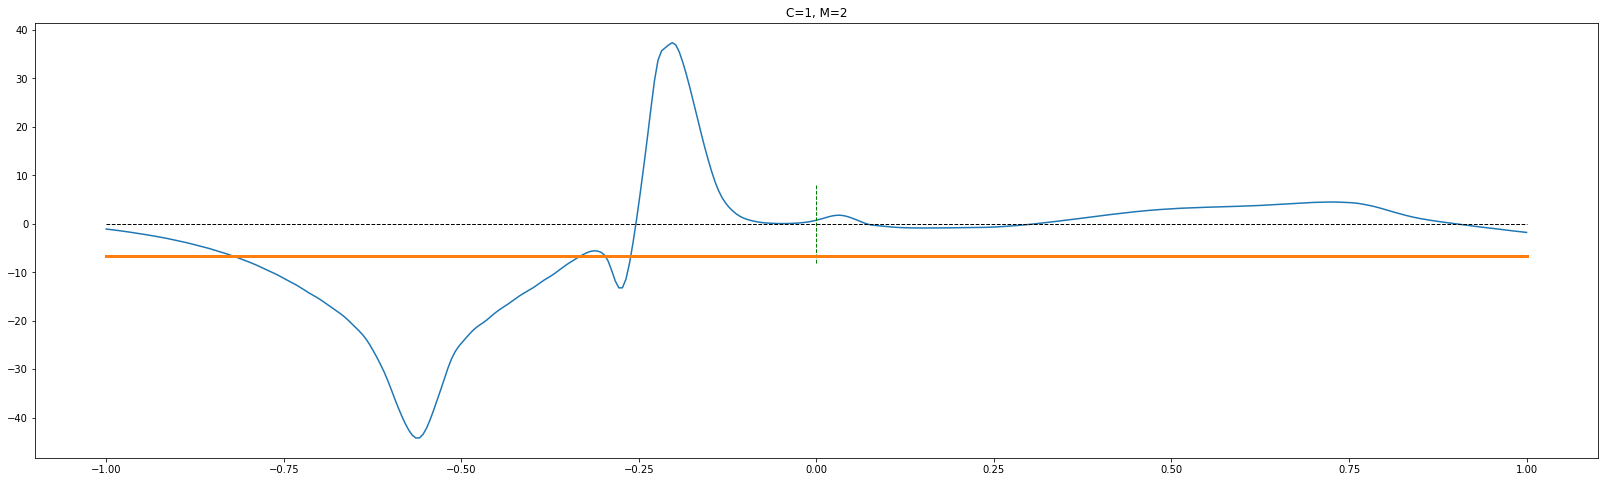

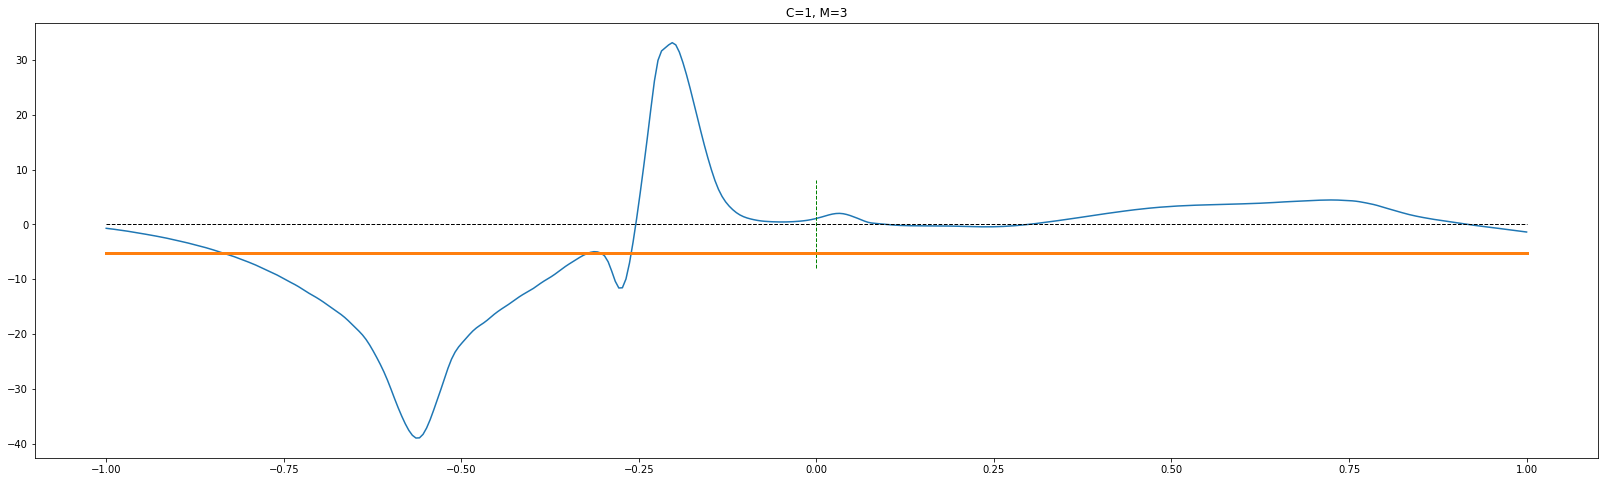

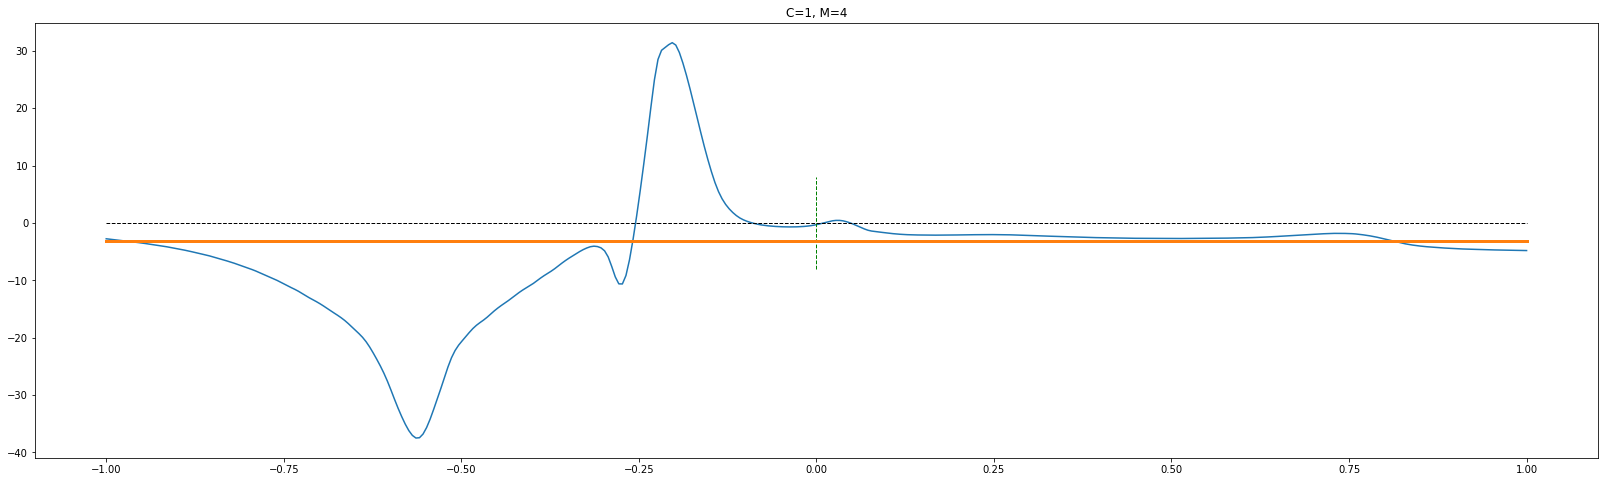

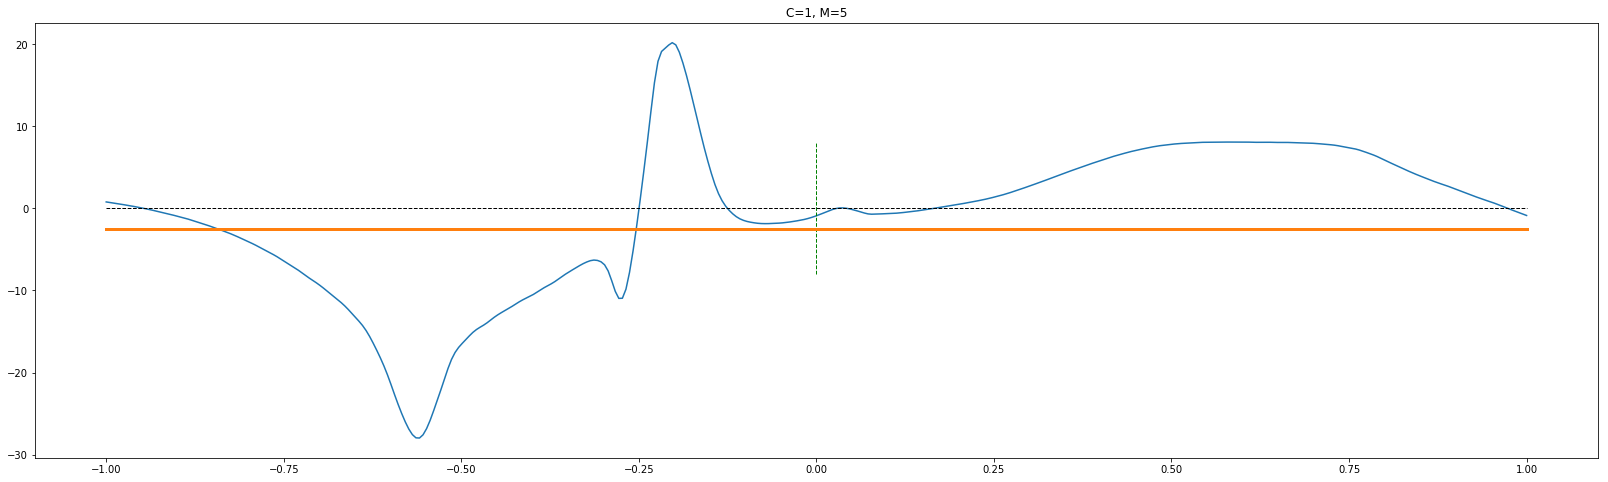

In [17]:
# CLOSEUP OF SOME CORRELATIONS: 1000 s, 0.5 s
span = 200
t = np.linspace(-span*net.min_delay, span*net.min_delay, 2*span)
c = 1
for m in range(6):
    corr = np.correlate(-CED_diff_center[:,c], MD_diff_center[:,m], mode='same')
    fig = plt.figure(figsize=(28,8))
    x = int(len(corr)/2)
    plt.plot(t, corr[x-span:x+span])
    plt.plot([0, 0], [-8., 8], 'g--', linewidth=1)
    plt.plot(t, np.zeros(2*span), 'k--', linewidth=1)
    plt.plot(t, 4.*M__CE_w[c][m]*np.ones(2*span), linewidth=3)
    plt.title('C=%d, M=%d' % (c,m))

In [12]:
# checking some connections
print("Connections to motor units")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[AF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'A'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")
    
print("Connections to spinal units")
for idx, syn in enumerate(net.syns[CE[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CE, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")

for idx, syn in enumerate(net.syns[CI[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_type is plant_models.planar_arm_v3:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in CE:
        pre_pop = 'CE'
    elif pre_id in CI:
        pre_pop = 'CI'
    else:
        pre_pop = 'other'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> CI, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
print("-------------------------\n")


print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in AL:
        pre_pop = 'AL'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
print("-------------------------\n")

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P:
        pre_pop = 'P'
    elif pre_id in AF:
        pre_pop = 'AF'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    elif pre_id in M:
        pre_pop = 'M'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

Connections to motor units
0) AF (1) --> M, w=0.268818, port=0, plant_out=None
1) AF (2) --> M, w=0.579158, port=0, plant_out=None
2) AF (3) --> M, w=1.254868, port=0, plant_out=None
3) AF (4) --> M, w=1.081252, port=0, plant_out=None
4) AF (5) --> M, w=-0.044751, port=0, plant_out=None
5) AF (6) --> M, w=1.066118, port=0, plant_out=None
6) AF (19) --> M, w=1.220718, port=0, plant_out=None
7) AF (20) --> M, w=2.157793, port=0, plant_out=None
8) AF (21) --> M, w=-0.478650, port=0, plant_out=None
9) AF (22) --> M, w=0.370174, port=0, plant_out=None
10) AF (23) --> M, w=0.838644, port=0, plant_out=None
11) AF (24) --> M, w=0.639055, port=0, plant_out=None
12) SPF (92) --> M, w=2.000000, port=1, plant_out=None
13) erroneous (91) --> M, w=1.000000, port=2, plant_out=None
-------------------------

Connections to afferent units
0) other (0) --> A, w=1.000000, port=0, plant_out=None
-------------------------

Connections to spinal units
0) M (55) --> CE, w=-1.146830, port=0, plant_out=None
1)

---

In [ ]:
#Animation of the arm and muscles
%matplotlib widget
from numpy import cos, sin
from matplotlib.animation import FuncAnimation

# angles of shoulder and elbow
theta_s = arm_activs[:,0]
theta_e = arm_activs[:,2]
phi = theta_s + theta_e # elbow angle wrt x axis
# data from tracking units
acts = np.array(data[1])
ipx = data[ipx_track]
ipy = data[ipy_track]
ten = arm_activs[:, np.array(range(4,10))].transpose()
# coordinates of hand and elbow
l1 = net.plants[P].l_arm
l2 = net.plants[P].l_farm
xe = cos(theta_s)*l1
ye = sin(theta_s)*l1
xh = xe + cos(phi)*l2
yh = ye + sin(phi)*l2
# creating the figure and axis
fig = plt.figure(figsize=(8,8))
plt.axis('equal')
ax = plt.gca()
lim = l1 + l2
ax.set_xlim([-lim, lim])
ax.set_ylim([-lim, lim])
ax.grid()
# creating lines and points
line, = ax.plot([], [], 'o-b', lw=2)
points, = ax.plot([], [], '+k')
target, = ax.plot([], [], 'gD')
# preparing a colormap for the tensions
ten_max = max(ten.max(), 1e-5)
ten_min = min(ten.min(), -1e-5)
for row_idx, row in enumerate(ten):
    for ent_idx, entry in enumerate(row):
        if entry > 0:
            ten[row_idx, ent_idx] = entry/ten_max
        else:
            ten[row_idx, ent_idx] = entry/abs(ten_min)
#ten = (ten / 2.) + 0.5 # we'll have only positive tensions
mus_lines = []
#cmap=plt.get_cmap('Reds')
#cmap=plt.get_cmap('coolwarm')
cmap=plt.get_cmap('bwr')
for i in range(6):
    mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
# stuff used to plot the target
strt_idx = int(np.round(times[0]/t_pres)) # initial index in m_idxs

def init():
    line.set_data([], [])
    points.set_data([], [])
    for i in range(6):
        mus_lines = []
        mus_lines.append(ax.plot([], [], color=cmap(0.5))[0])
    return line, points, mus_lines

def update(frame):
    coord_x = [0, xe[frame], xh[frame]]
    coord_y = [0, ye[frame], yh[frame]]
    ip_x = ipx[:,frame]
    ip_y = ipy[:,frame]
    tens = ten[:, frame]
    line.set_data(coord_x, coord_y)
    points.set_data(ip_x, ip_y)
    for i, ml in enumerate(mus_lines):
        idx = 2*i
        ml.set_data(ip_x[idx:idx+2], ip_y[idx:idx+2])
        ml.set_color(cmap(tens[i]))
    
    cur_time = frame*net.min_delay
    fig.suptitle('time: ' + '{:f}'.format(cur_time))
    # plotting target
    cur_idx = int(cur_time/t_pres) + strt_idx
    x_coord, y_coord = hand_coords[m_idxs[cur_idx]]
    target.set_data([x_coord], [y_coord])
    
    return line, points, mus_lines #muscle1

ani = FuncAnimation(fig, update, frames=np.arange(0, len(theta_s), 20), init_func=init, blit=True, interval=20)

plt.show()

In [48]:
# Doing a nice print of the AF__M weights in order to initialize them
AF__M_w = np.zeros((len(M), 12))
for idx, mid in enumerate(M):
    AF__M_w[idx, :] = np.array([syn.w for syn in net.syns[mid] if syn.preID in AF])
      
import re

stryn = re.sub('\[,', '[', re.sub('\ +', ', ', str(AF__M_w)))
for c,s in enumerate(re.split(', ', stryn)):
    print(s, end=',')
    if (c+1)%12 == 0: print('\n')


[[ 1.93802617e-01,1.38242693e-01,1.72816236e+00,1.21019986e+00
,-6.42849913e-01,2.46505565e+00,-2.81279804e-01,-1.65095052e-01
,-9.64704328e-01,-6.60402868e-01,2.62293521e-01,-1.30185034e+00]
,

[ 6.05060206e-01,-8.86383858e-01,1.30771236e+00,7.03047088e-01
,-1.96372366e+00,1.35434052e+00,-8.29490259e-01,-3.75494828e-02
,-5.47927080e-01,-2.28397827e-01,8.33304322e-01,-7.11248584e-01]
,

[ 5.33435900e-01,2.53140215e+00,-8.66032940e-01,-3.93452697e-01
,2.38905974e+00,-3.38526735e-01,1.22683927e-01,-1.22152195e+00
,-1.71490940e-02,-2.30628265e-01,-1.13683801e+00,2.36777207e-01]
,

[ 5.20442867e-01,1.10452952e+00,-5.72936333e-01,-3.20346732e-01
,3.18793390e+00,-1.05125910e+00,-2.63578122e-01,-6.84695533e-01
,1.84401410e-01,-2.57560565e-02,-1.57020442e+00,5.21624255e-01]
,

[ 1.92048630e-01,1.26735244e+00,1.44344334e+00,8.53352468e-01
,-7.17917174e-01,1.93450497e+00,-2.38151809e-01,-6.65951263e-01
,-8.99436978e-01,-4.42945348e-01,2.39946185e-01,-1.12038986e+00]
,

[ 3.63043022e-01,1.1443942

In [6]:
# Cell used to adjust parameters affecting the range of SF values
# corresponding to the various targets

# In the first cell we calculated the AF output for the 8 targets.
# It is in the AF_Ia_II array, which is 8x12
# We reduce AF_Ia_II in three ways: maximum, minimum, and mean for all targets
AF_max = np.max(AF_Ia_II, axis=0)
AF_min = np.min(AF_Ia_II, axis=0)
AF_mean = np.mean(AF_Ia_II, axis=0)
AF_spread = AF_max - AF_min

# We adjust the SF parameters so the mean output averaged over targets is 
# around 0.5,and the spread is around 0.6. One way is to set 
# 1) All AF__SF weights to 1,
# 2) The threshold equal to the AF_mean value (target average)
# 3) The slope inversely related to the spread, as in slope = max_slope/(1.+ a*spread)
max_slope = 12.
a = 5.
slopes = max_slope / (1. + a*AF_spread)
print("Recommended AF__SF weights: 1 ", end="\n\n")
print("Recommended SF thresholds: ")
print(AF_mean, end="\n\n")
print("Recommended SF slopes: ")
print(slopes, end="\n\n")


Recommended AF__SF weights: 1 

Recommended SF thresholds: 
[0.02051586 0.03230201 0.01017465 0.01276559 0.02716843 0.03277251
 0.02916627 0.04708436 0.01437482 0.00496981 0.04492718 0.03762306]

Recommended SF slopes: 
[10.3748608   7.82919646  9.46788888 10.49932696  8.6980101   8.70497844
  9.30664232  6.60950129  8.55607539 10.68044915  7.41169433  8.06923034]



In [12]:
# Cell used to adjust parameters affecting the range of SF values
# corresponding to the various targets

min_len = np.min(m_lengths, axis=0) # m_lengths, etc. calclulated in the first cell
max_len = np.max(m_lengths, axis=0)
mean_lens = np.mean(m_lengths, axis=0)
#print('length for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_len, max_len, mean_len))
print('length spreads: ')
print(max_len - min_len)

# These lengths are used to obtain steady state tensions assuming zero velocity and
# no gamma inputs. The steady state tensions are then used to produce steady state
# Ia and II outputs Ia_ss and II_ss.

# Using Ia_ss and II_ss the steady state output of the AF population is obtained.
# This output comes from Ia and II minus their average values. We assume that these
# values change slowly relative to the change in the target, or otherwise they would
# approach the steady state of Ia and II for the present target. Moreover, we assume
# that SP knows these averages.

# We recommend weigths so the AF output for the mean target length is around 0.5
par = net.plants[P].m_params
Ts_ss_ml = (par['k_se_s']/(par['k_se_s']+par['k_pe_s'])) * (
            par['k_pe_s']*(mean_lens - par['l0_s']))
Td_ss_ml = (par['k_se_d']/(par['k_se_d']+par['k_pe_d'])) * (
            par['k_pe_d']*(mean_lens - par['l0_d']))
Ia_ss_ml = par['fs']*(Ts_ss_ml/par['k_se_s']) + (1.-par['fs'])*(Td_ss_ml/par['k_se_d'])
II_ss_ml = par['se_II']*(Ts_ss_ml/par['k_se_s']) + ((1.-par['se_II'])/par['k_pe_s'])*Ts_ss_ml
Ia_ss_ml *= par['Ia_gain']
II_ss_ml *= par['II_gain']
AF_ml = np.concatenate((Ia_ss_ml, II_ss_ml), axis=0)
# Next transformation is through the chwr_linear afferent units
#AF_Ia = np.maximum(Ia_ss*Pe__AF_Ia_ws - AF_avgs[0:6] - AF_thr[0:6], 0.)
#AF_II = np.maximum(II_ss*Pe__AF_II_ws - AF_avgs[6:12] - AF_thr[6:12], 0.)
# 0.5 = (Ia_ss_ml - AF_avgs[muscl])*w_Ia - AF_thr[muscl]
# 0.5 = (II_ss_ml - AF_avgs[6+muscl])*w_II - AF_thr[6+muscl]
w = (0.5 + AF_thr)/(AF_ml - AF_avgs)
print("Recommended P__AF_syn['init_w']:")
print(w)

# Next we want the  mean_aff value to produce sp output of roughly 0.5,
# and we want an sp spread of roughly 0.6 .
# This implies SF_params['thresh'] ~= 0.5*AF__SF_syn['init_w'], 
# and a SF_params['slope'] = s such that
# sig(max_aff) - sig(min_aff) = 0.6, so
# 1/(1+exp(-s*(max_aff-thr))) - 1/(1+exp(-s(min_aff-thr))) = 0.6

# For the second criterion min_aff is always 0, but mean_aff changes
# SF_params['thresh'] = AF__SF_syn['init_w']*mean_aff
# 1/(1+exp(-slope*(max_aff-thr))) - 1/(1+exp(slope*thr)) = 0.6

#sp_vals = sf_preds[:,muscl]
#min_sp = min(sp_vals)
#max_sp = max(sp_vals)
#mean_sp = np.mean(sp_vals)
#print('SP for muscle %d: min=%f, max=%f, mean=%f' % (muscl, min_sp, max_sp, mean_sp))
#print('sp spread = %f' %(max_sp - min_sp))

length spreads: 
[0.0208856  0.03423837 0.03386777 0.0190577  0.02544564 0.0237055 ]
Recommended P__AF_syn['init_w']:
[ -3.51294416 -15.81415791  -1.0082549   -2.36447156  -1.68367397
  -4.04527051  17.15133356   7.76963701  -3.86862005 -28.94024146
 -21.0155792   29.71014218]


shoulder angle: 1.442626, shoulder vel: 2.603231
AFe_data:
[0.17594442 0.17842449 0.10631457 0.1115052  0.17691859 0.12048957
 0.04233172 0.00857457 0.14856416 0.16923824 0.00527977 0.27012538
 0.030322   0.00101813 0.20372429 0.16577585 0.01662294 0.18890435]
AFi_data:
[1.14531031e-004 1.03529910e-004 3.09542345e-002 3.46612874e-002
 4.83168414e-005 2.56973835e-002 7.81214615e-002 1.74745667e-001
 2.75372074e-004 5.87445463e-004 1.15323954e-001 7.94922730e-003
 4.35600640e-175 1.05376516e-001 6.27264921e-175 5.05296742e-175
 4.70448691e-175 3.72968378e-004]


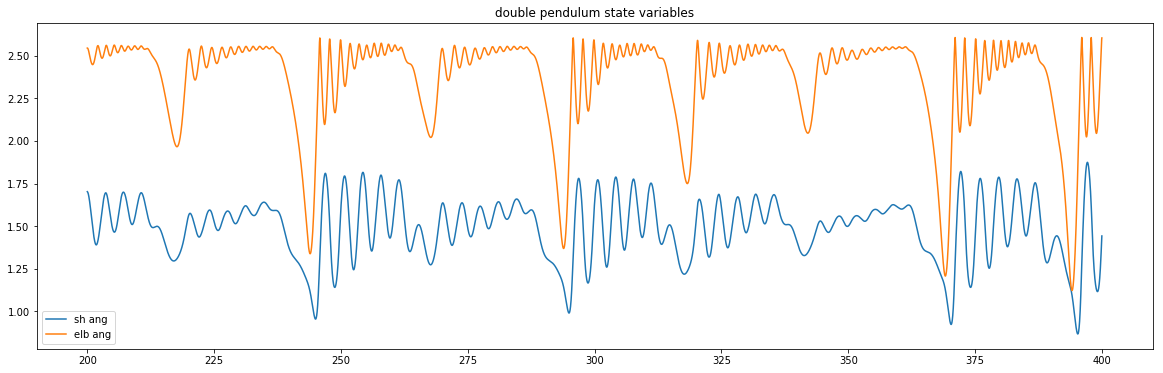

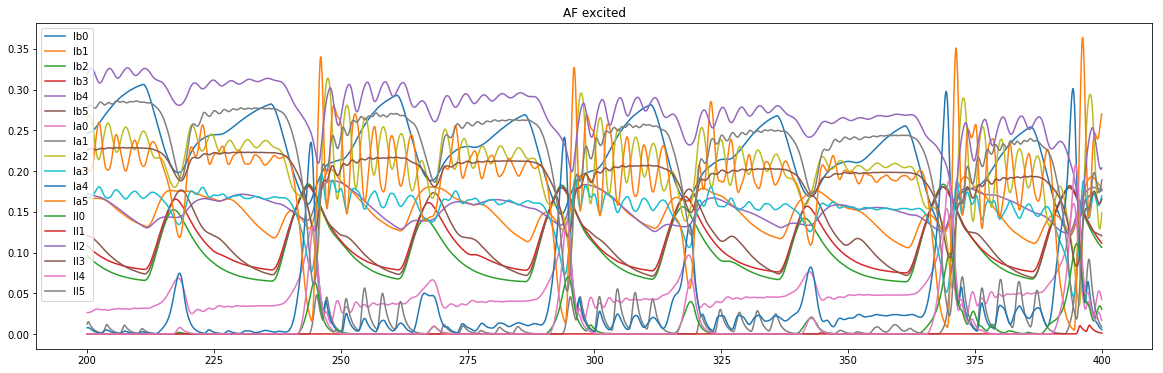

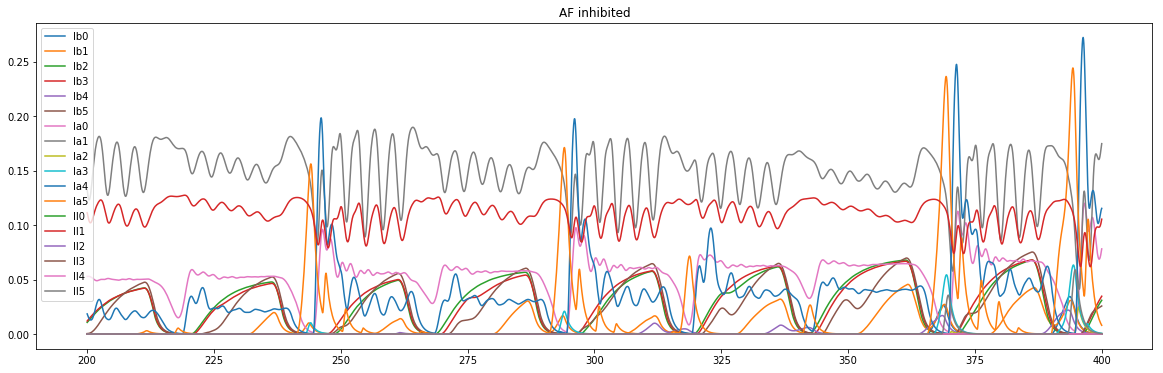

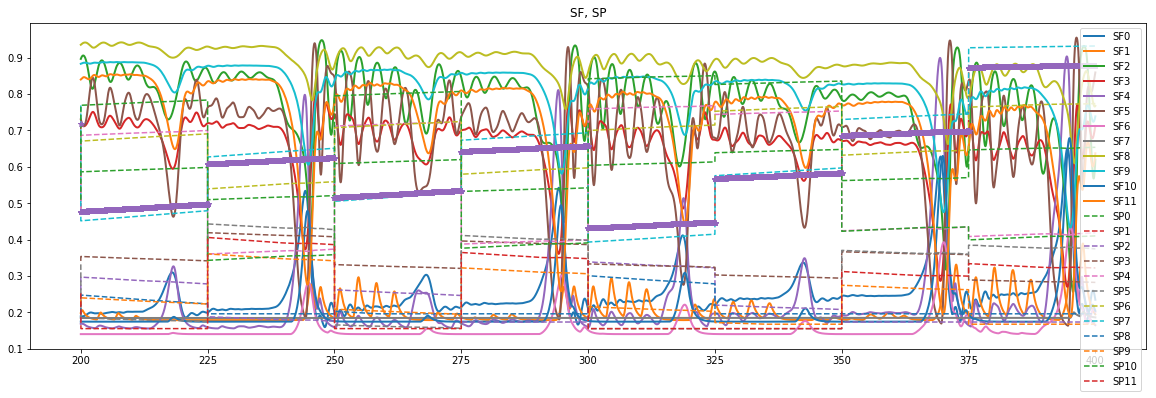

SF = 
[0.23451861 0.19450425 0.61903294 0.71200928 0.16464123 0.85900059
 0.20120289 0.18593608 0.76729315 0.73826688 0.20391819 0.63682702]
SP = 
[0.65334708 0.87772307 0.17328104 0.28212748 0.418632   0.3742038
 0.77347578 0.93167394 0.19585579 0.16728396 0.40985734 0.32181886]


In [17]:
# P
P_fig = plt.figure(figsize=fs)
P_state = plant_data[P][:,0:4:2]
plt.plot(times, P_state)
#plt.legend(['sh ang', 'sh ang vel', 'elb ang', 'elb ang vel'])
plt.legend(['sh ang', 'elb ang',])
plt.title('double pendulum state variables')
print("shoulder angle: %f, shoulder vel: %f" % (P_state[-1,0],P_state[-1,1]))

# AF plus
AFe_fig = plt.figure(figsize=fs)
AFe_data = np.array(data[AF[0:18]])
plt.plot(times, AFe_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF excited')
print('AFe_data:')
print(AFe_data[:,-1])

# AF minus
AFi_fig = plt.figure(figsize=fs)
AFi_data = np.array(data[AF[18:36]])
plt.plot(times, AFi_data.transpose())
AF_legends = ['Ib' + str(i) for i in range(6)] + \
             ['Ia' + str(i) for i in range(6)] + \
             ['II' + str(i) for i in range(6)]
plt.legend(AF_legends)
plt.title('AF inhibited')
print('AFi_data:')
print(AFi_data[:,-1])

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), linewidth=2)
plt.plot(times, SP_data.transpose(), '--')
plt.plot(times, SP_data[1,:], '*')
SF_legends = ['SF'+str(i) for i in range(len(SF))]
SP_legends = ['SP'+str(i) for i in range(len(SP))]
plt.legend(SF_legends+SP_legends)
plt.title('SF, SP')
plt.show()
print('SF = ')
print(SF_data[:,-1])
print('SP = ')
print(SP_data[:,-1])

In [24]:
# extracting afferent means
Ia_means = np.zeros(6)
II_means = np.zeros(6)
Ib_means = np.zeros(6)
for m in range(6):
    Ia_means[m] = np.mean(arm_activs[:,28+m])
    II_means[m] = np.mean(arm_activs[:,34+m])
    Ib_means[m] = np.mean(arm_activs[:,22+m])
print(Ia_means)
print(II_means)
print(Ib_means)

[ 0.13493085  0.12699591  0.13034749  0.06348308  0.23278596 -0.02502041]
[0.3317177  0.26290762 0.26859266 0.21690979 0.40901287 0.08413031]
[0.06734463 0.06212599 0.08832295 0.13052798 0.06396478 0.11577913]


In [10]:
AF_avgs

array([0.24, 0.1 , 0.64, 0.31, 0.43, 0.2 , 0.24, 0.11, 0.43, 0.29, 0.3 ,
       0.17])

In [71]:
# removing feedback to compare with Fink et al.
for uid in CE+CI:
    syn_list = net.syns[uid]
    for syn in syn_list:
        if syn.preID in AF:
            #syn.w = 0.
            syn.alpha = 1.
            syn.normalize = False